## News Classification
#### Maciej Odziemczyk 
#### Table of contents
 - data loading
     - target variable analysis, validation method choice and train/validation/test split
 - training data analysis, all data preprocessing
     - cleaning
     - word clouds
     - stop words
     - lemmatization
 - feature engineering:
     - titles lengths measures
     - titles sentiment
     - named entity recognition
         - groups of tags
         - most frequent tags
     - n-grams
         - most frequent unigrams and bigrams
 - GloVe word embeddings
 - modelling
 - evaluation

In [27]:
import numpy as np                                              # linear algebra
import pandas as pd                                             # data manipulations
import matplotlib.pyplot as plt                                 # plots
import seaborn as sns                                           # nicer plots
import nltk                                                     # nlp tools
import spacy                                                    # SpaCy model for NER and lemmatization
import re                                                       # regex
import pickle                                                   # binary saving
import ast                                                      # proper casting
from wordcloud import WordCloud,STOPWORDS                       # words clouds plots and stop list
from nltk.sentiment.vader import SentimentIntensityAnalyzer     # VADER sentiment analyzer
from sklearn.preprocessing import LabelEncoder                  # label encoding
from sklearn.model_selection import train_test_split            # train test split
from timeit import default_timer as timer                       # time measure
from sklearn.metrics import confusion_matrix                    # confusion matrix

# tensorflow/keras - Deep Learning
import tensorflow as tf                                         # tensorflow background
from tensorflow import keras                                    # keras API for tensorflow
from tensorflow.keras import layers                             # keras layers
from tensorflow.keras import models                             # keras models
from tensorflow.keras import optimizers                         # keras optimizers
from tensorflow.keras import activations                        # keras activation functions
from tensorflow.keras import losses                             # keras loss functions 
from tensorflow.keras import regularizers                       # keras regularizers
from keras.utils import np_utils                                # one-hotting

### data loading
In this section the data is loaded, validation method is chosen and target variable is analyzed.

In [2]:
# list of features mentioned in readme.txt excluding ID column
features = ["TITLE", "URL", "PUBLISHER", "CATEGORY", "STORY", "HOSTNAME", "TIMESTAMP"]
# data loading
data = pd.read_csv(r"data/newsCorpora.csv", sep="\t", names= features, header=None,
                   usecols=[i for i in range(1,len(features)+1)])

In [3]:
# How the data looks like?
data.head()

TITLE  \
0  Fed official says weak data caused by weather,...   
1  Fed's Charles Plosser sees high bar for change...   
2  US open: Stocks fall after Fed official hints ...   
3  Fed risks falling 'behind the curve', Charles ...   
4  Fed's Plosser: Nasty Weather Has Curbed Job Gr...   

                                                 URL          PUBLISHER  \
0  http://www.latimes.com/business/money/la-fi-mo...  Los Angeles Times   
1  http://www.livemint.com/Politics/H2EvwJSK2VE6O...           Livemint   
2  http://www.ifamagazine.com/news/us-open-stocks...       IFA Magazine   
3  http://www.ifamagazine.com/news/fed-risks-fall...       IFA Magazine   
4  http://www.moneynews.com/Economy/federal-reser...          Moneynews   

  CATEGORY                          STORY             HOSTNAME      TIMESTAMP  
0        b  ddUyU0VZz0BRneMioxUPQVP6sIxvM      www.latimes.com  1394470370698  
1        b  ddUyU0VZz0BRneMioxUPQVP6sIxvM     www.livemint.com  1394470371207  
2        b  ddUyU0VZz0BRneMioxUPQVP6sIxvM  www.ifamagazine.com  1394470371550  
3        b  ddUyU0VZz0BRneMioxUPQVP6sIxvM  www.ifamagazine.com  1394470371793  
4        b  ddUyU0VZz0BRneMioxUPQVP6sIxvM    www.moneynews.com  1394470372027

The task is to build a news classifier for the websites not present in the dataset. Definitely URL, HOSTNAME and TIMESTAMP has to be deleted because these are charactersitics for the websites present in the dataset. PUBLISHER column is related to the HOSTNAME one, so it should be dropped too.

In [5]:
# columns dropping
data.drop(labels=["URL", "HOSTNAME", "TIMESTAMP", "PUBLISHER"], axis=1, inplace=True)

In [6]:
# dataset after columns dropping
data.head()

TITLE CATEGORY  \
0  Fed official says weak data caused by weather,...        b   
1  Fed's Charles Plosser sees high bar for change...        b   
2  US open: Stocks fall after Fed official hints ...        b   
3  Fed risks falling 'behind the curve', Charles ...        b   
4  Fed's Plosser: Nasty Weather Has Curbed Job Gr...        b   

                           STORY  
0  ddUyU0VZz0BRneMioxUPQVP6sIxvM  
1  ddUyU0VZz0BRneMioxUPQVP6sIxvM  
2  ddUyU0VZz0BRneMioxUPQVP6sIxvM  
3  ddUyU0VZz0BRneMioxUPQVP6sIxvM  
4  ddUyU0VZz0BRneMioxUPQVP6sIxvM

Is there any useful information in STORY column? According to readme.txt STORY is "Alphanumeric ID of the cluster that includes news about the same story". According to UCI dataset description "The resources are grouped into clusters that represent pages discussing the same story" where pages means actually news itself (can be guessed). The task is to built a classifier for unseen webpages, so clusters for observations present in the dataset seems not to be a good source of information. Conclusion: STORY column should be dropped.

In [7]:
# STORY dropping
data.drop(labels=["STORY"], axis=1, inplace=True)

To get more familiar with the problem target variable distribution has to be inspected. Countplot below

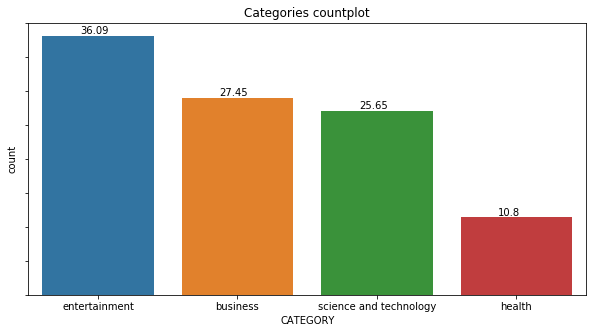

In [8]:
# countplot
fig, ax = plt.subplots(figsize=(10,5))
ax=sns.countplot(x="CATEGORY", data=data, order=data["CATEGORY"].value_counts().index)

# add ticks with percentage
for p, label in zip(ax.patches, np.round(data["CATEGORY"].value_counts()/data.shape[0]*100,2)):
    ax.annotate(label, (p.get_x()+0.27, p.get_height()+1000))

ax.set_yticklabels([])
ax.set_xticklabels(["entertainment", "business", "science and technology", "health"])
ax.set_title("Categories countplot")
plt.show()

Most cases from the entertainment category, least from health, business and science occurances are similar. Accuracy is not a good metric. To decide about metric and evaluation method number of observations is needed (if there are enough observations, a simple train/validation/test split will suffice.

In [9]:
print("number of observations:", data.shape[0])

number of observations: 422419


The number of observations is too big for n-fold cross validation. Stratified train, dev, test split should be enough. Because is multiclass classification to evaluate model performance confusiom matrix will be used.
Chosen proportions are 0.7 train set, 0.15 validation set and 0.15 test set.

In [10]:
# to do split quickly sklearn train_test_split() function is used two times, first data is splitted in train and test set
# and after that validation set is separated from the train set. Adjustment was needed, first split is 0.13 and second 
# 0.15 

# train/test split
X_train, X_test, y_train, y_test = train_test_split(data.TITLE, data.CATEGORY, test_size=0.13, random_state=2021,
                                                    stratify=data.CATEGORY)

# train/validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=2021, 
                                                  stratify=y_train)

In [11]:
# double check for splitting, class balance in sets inspection
print(y_train.value_counts()/y_train.shape[0],"\nTrain set size:",X_train.shape[0],"\n")
print(y_val.value_counts()/y_val.shape[0], "\nValidation set size:",X_val.shape[0],"\n")
print(y_test.value_counts()/y_test.shape[0],"\nTest set size:",X_test.shape[0])

e    0.360944
b    0.274530
t    0.256484
m    0.108042
Name: CATEGORY, dtype: float64 
Train set size: 312378 

e    0.360937
b    0.274535
t    0.256485
m    0.108043
Name: CATEGORY, dtype: float64 
Validation set size: 55126 

e    0.360940
b    0.274533
t    0.256487
m    0.108040
Name: CATEGORY, dtype: float64 
Test set size: 54915


Split is done correctly.

### training data analysis and all sets preprocessing
In this section all the sets are preprocessed based on the train set analysis and with its charactersitics to prevent information leakage. The very first thing is a quick look at the training examples for each class.

In [12]:
# data frame building (it is easier to work with)
train_set=pd.concat((X_train,y_train), axis=1)
val_set=pd.concat((X_val,y_val), axis=1)
test_set=pd.concat((X_test,y_test), axis=1)

# deleting old variables (memory saving, it is pretty big dataset)
del X_train
del y_train
del X_val
del y_val
del X_test
del y_test
del data

In [14]:
# train examples inspection
grouped=train_set.groupby(by="CATEGORY")

for category in grouped.groups.keys():
    grouped_curr=grouped.get_group(category).sample(frac=1, random_state=2021)
    print("\nCategory: {}".format(category))
    for i in range(5):
        print("{}".format(grouped_curr.iloc[i,0]))


Category: b
In odd twist, industry agrees to ban microbeads
US May trade deficit shrinks as exports fly off shores
GM's 2014 Recall Tally Tops 20 Million As Ignition-Switch Recall Doubles
Argentine Bonds Plunge After U.S. Supreme Court Rejects Appeal
Microsoft reports Commercial segment growth in third quarter results

Category: e
Lana Del Rey Releases 'Shades Of Cool' Video
Rough draft of Bob Dylan's 'Like a Rolling Stone' sells for $2 million
Tracing the Steps of Jesus on Good Friday
Beyoncé, Jennifer Garner Unite for 'Ban Bossy' Girl Empowerment Campaign
Mickey Rooney's family settles on Hollywood burial site

Category: m
Ebola Death Toll at 61 in Guinea
Medical Marijuana & Brain Diseases
Fight Blindness with Coffee
Sun Protection Advice for Sailors
Life expectancy has risen worldwide

Category: t
Giant hole at 'the end of the world' in Yamal, Siberia could be the result of global  ...
It's Dre day
Android 4.4 KitKat Update for Samsung Galaxy Note 3 Confirmed
IBM Deepens Move to Co

It looks like there are observations with cutted titles what is representent by "...". Health topic should be the easiest one, because of special vocabulary and maybe there is also a pattern that mediacal news are the shortest? Entertainment looks like the harders can be based on the celibrities and shows names.<br>
The next step is to ceal up the data a bit: lowercasing, punctuation removing.<br>

Note: 
 - quotation marks are important, because of contractions, it has to be treated independently (contractions_removal() function), because it could help with sentiment analysis. Another quotation marks should be deleted
 - %, &, \$ can be informative, so it is better to transform it to the percent, and, dollar words
 - one letter words seems not to be informative as well, so it is better to delete it
 
#### data cleaning
in this subsection all sets are cleaned and stoplist are created based on words clouds analysis. First tokenization is performed too.

In [2]:
def contractions_removal(text):
    '''
    function that removes contractions, it has several simplifications: 
    's=is, not has
    'd=would, not had
    
    arguments:
    text - input (string)
    
    to combine with pd.series.apply(lambda x: contractions_removal(x))
    
    return text with removed contractions 
    '''
    
    # to be peresnt simple to be
    text=re.sub("i'm", "i am", text)
    text=re.sub("you're", "you are", text)
    text=re.sub("he's", "he is", text)     # simplification, could be he has also
    text=re.sub("she's", "she is", text)   # simplification, could be she has also
    text=re.sub("it's", "it is", text)     # simplification, could be it has also
    text=re.sub("we're", "we are", text)
    text=re.sub("they're", "they are", text)
    # present simple negations
    text=re.sub("don't", "do not", text)
    text=re.sub("doesn't", "does not", text)
    # present perfect to be
    text=re.sub("i've", "i have", text)
    text=re.sub("you've", "you have", text)
    text=re.sub("we've", "we have", text)
    text=re.sub("they've", "they have", text)
    # present perfect negations
    text=re.sub("haven't", "have not", text)
    text=re.sub("hasn't", "has not", text)
    # future simple to be
    text=re.sub("i'll", "i will", text)
    text=re.sub("you'll", "you will", text)
    text=re.sub("he'll", "he will", text)
    text=re.sub("she'll", "she will", text)
    text=re.sub("it'll", "it will", text)
    text=re.sub("we'll", "we will", text)
    text=re.sub("they'll", "they will", text)
    # future simple negations
    text=re.sub("won't", "will not", text)
    # would... there are lots of simplification, could be had also, but in news would should occur more often
    text=re.sub("i'd", "i would", text)
    text=re.sub("you'd", "you would", text)
    text=re.sub("he'd", "he would", text)
    text=re.sub("she'd", "she would", text)
    text=re.sub("it'd", "it would", text)
    text=re.sub("we'd", "we would", text)
    text=re.sub("they'd", "they would", text)
    # would negation
    text=re.sub("wouldn't", "would not", text)
    # another negations
    text=re.sub("aren't", "are not", text)
    text=re.sub("can't", "can not", text)
    text=re.sub("couldn't", "could not", text)
    text=re.sub("mustn't", "must not", text)
    text=re.sub("wasn't", "was not", text)
    text=re.sub("weren't", "were not", text)
    text=re.sub("shouldn't", "should not", text)
    text=re.sub("ain't", "not", text)     # simplification, ain't is multipurpose
    # another contractions
    text=re.sub("who'd", "who would", text)
    text=re.sub("who've", "who have", text)
    text=re.sub("who's", "who is", text)
    text=re.sub("should've", "should have", text)
    text=re.sub("must've", "must have", text)
    text=re.sub("could've", "could have", text)
    text=re.sub("hadn't", 'had not', text)
    text=re.sub("let's", 'let us', text)
    text=re.sub("that's", 'that is', text)
    
    return text

In [3]:
def cleaning(text, lowercase, special_chars_replace, alphanumeric_only, spaces, longer_than_one_letter, tokenize):
    '''
    function for data text data cleaning, arguments:
    text - input (string)
    lowercase - bool, lowercasting all the letters
    special_chars_replace - bool, converting %,&,$ to words and removing contractions
    alphanumeric_only - bool, remove all the characters not in [a-zA-Z0-9]
    spaces - bool, remove unnecessary spaces 
    longer_tha_one_letter - bool, remove one-letter words
    tokenize - bool, apply tokenization
    
    return cleaned text (str)
    '''
    if lowercase:
        text=text.lower()
    
    if special_chars_replace:
        # transform % to percent
        text = re.sub("[%]", " percent", text)
        # transform & to and
        text = re.sub("[&]", " and", text)
        # transform $ to dollar
        text = re.sub("[$]", " dollar ", text)
        # remove contractions
        text = contractions_removal(text)
    
    if alphanumeric_only:
        # remove all non alphanumeric characters
        text=re.sub("[^a-zA-Z0-9]", " ", text)
        
    if spaces:
        # remove repeated spaces
        text=re.sub(" +", " ", text)
        
    if longer_than_one_letter:
        # remove all single LETTER words
        text=text.split()
        text=[t for t in text if (len(t) > 1) or (t.isdigit())]
        text=" ".join(text)
        
    if tokenize:
        text=text.split()
        
    return text

In [17]:
# train set cleaning
train_set["TITLE_clean"]=train_set.TITLE.copy()
train_set["tokens"]=train_set.TITLE.copy()
train_set.TITLE_clean=train_set.TITLE_clean.apply(lambda x: cleaning(x, True, True, True, True, True, False))
train_set.tokens=train_set.tokens.apply(lambda x: cleaning(x, True, True, True, True, True, True))

# validation set cleaning
val_set["TITLE_clean"]=val_set.TITLE.copy()
val_set["tokens"]=val_set.TITLE.copy()
val_set.TITLE_clean=val_set.TITLE_clean.apply(lambda x: cleaning(x, True, True, True, True, True, False))
val_set.tokens=val_set.tokens.apply(lambda x: cleaning(x, True, True, True, True, True, True))

# train set cleaning
test_set["TITLE_clean"]=test_set.TITLE.copy()
test_set["tokens"]=test_set.TITLE.copy()
test_set.TITLE_clean=test_set.TITLE_clean.apply(lambda x: cleaning(x, True, True, True, True, True, False))
test_set.tokens=test_set.tokens.apply(lambda x: cleaning(x, True, True, True, True, True, True))

In [21]:
# cleaned training examples inspection
grouped=train_set.groupby(by="CATEGORY")

for category in grouped.groups.keys():
    grouped_curr=grouped.get_group(category).sample(frac=1, random_state=2021)
    print("\nCategory: {}".format(category))
    for i in range(5):
        print("{}".format(grouped_curr.iloc[i,2]))


Category: b
in odd twist industry agrees to ban microbeads
us may trade deficit shrinks as exports fly off shores
gm 2014 recall tally tops 20 million as ignition switch recall doubles
argentine bonds plunge after supreme court rejects appeal
microsoft reports commercial segment growth in third quarter results

Category: e
lana del rey releases shades of cool video
rough draft of bob dylan like rolling stone sells for dollar 2 million
tracing the steps of jesus on good friday
beyonc jennifer garner unite for ban bossy girl empowerment campaign
mickey rooney family settles on hollywood burial site

Category: m
ebola death toll at 61 in guinea
medical marijuana and brain diseases
fight blindness with coffee
sun protection advice for sailors
life expectancy has risen worldwide

Category: t
giant hole at the end of the world in yamal siberia could be the result of global
it is dre day
android 4 4 kitkat update for samsung galaxy note 3 confirmed
ibm deepens move to computer defense
utah g

In [22]:
# How the data looks now?
train_set.head()

TITLE CATEGORY  \
400178         Fist Bump vs. Hand Shake: Which Is Better?        m   
308819            HTC's 9-inch Nexus tablet leaked online        t   
3323    Neil Young's PonoPlayer delivers studio-qualit...        e   
403854  5 SECONDS OF SUMMER Announce 'Rock Out With Yo...        e   
168219  Ticket information for rescheduled Miley Cyrus...        e   

                                              TITLE_clean  \
400178            fist bump vs hand shake which is better   
308819              htc 9 inch nexus tablet leaked online   
3323    neil young ponoplayer delivers studio quality ...   
403854  5 seconds of summer announce rock out with you...   
168219  ticket information for rescheduled miley cyrus...   

                                                   tokens  
400178   [fist, bump, vs, hand, shake, which, is, better]  
308819      [htc, 9, inch, nexus, tablet, leaked, online]  
3323    [neil, young, ponoplayer, delivers, studio, qu...  
403854  [5, seconds, of, summer, announce, rock, out, ...  
168219  [ticket, information, for, rescheduled, miley,...

To get more familiar with data characterstics and create stoplist words clouds are prepared.

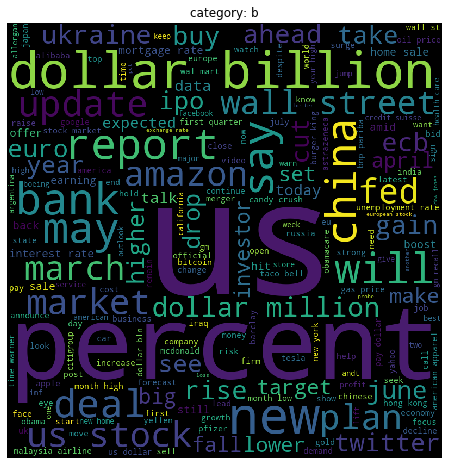

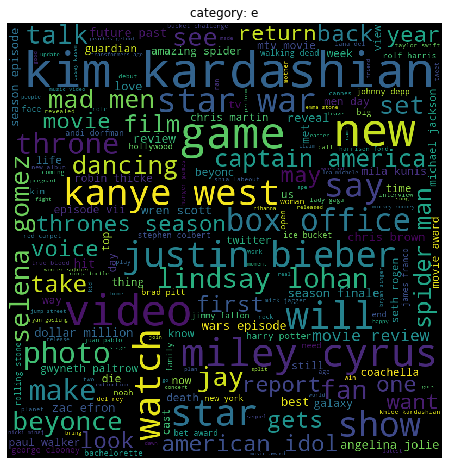

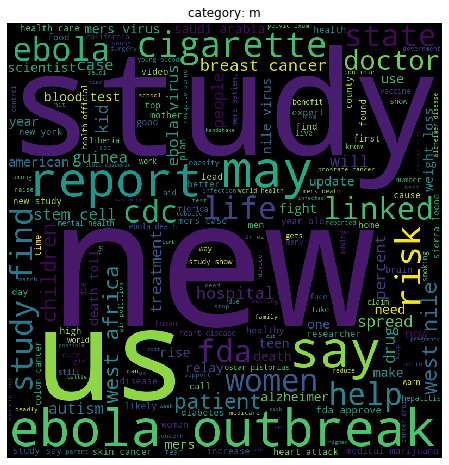

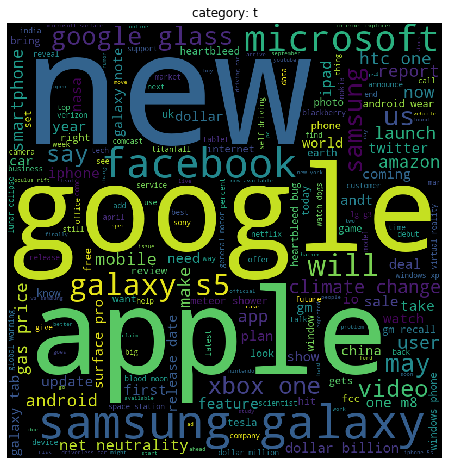

In [23]:
grouped=train_set.groupby(by="CATEGORY")

for category in grouped.groups.keys():
    plt.figure(figsize=(8,8))
    cloud=WordCloud(width=800,height=800, background_color="black", stopwords=None,
                    min_font_size=10, random_state=2021).generate(" ".join(grouped.get_group(category)["TITLE_clean"]))
    
    plt.imshow(cloud)
    plt.title('category: {}'.format(category))
    plt.axis('off')
    plt.show()

Very impressive results, clouds are very different and consistent with prior assumption: enterteinment is based on celebrities and shows names. <br>

NLTK and WordCloud packages' stoplists will be the core for the created one.

In [24]:
# How nltk stoplist looks like?
nltk_stoplist=nltk.corpus.stopwords.words(fileids="english")
nltk_stoplist

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [25]:
# How WordCloud stoplist looks like?
STOPWORDS

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'com',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'ever',
 'few',
 'for',
 'from',
 'further',
 'get',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'hence',
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 "let's",
 'like',
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'otherwise',
 'ought',
 'our',
 

lists look simillar, more sophisticated comparison is needed

In [26]:
# stoplists lengths
print("number of elements in nltk stoplist:", len(set(nltk_stoplist)))
print("number of elements in wordcloud stoplist:", len(STOPWORDS))

number of elements in nltk stoplist: 179
number of elements in wordcloud stoplist: 192


In [27]:
# size of the intersection
print("number of elements of the stoplists intersection:", len(set(nltk_stoplist).intersection(STOPWORDS)))

number of elements of the stoplists intersection: 144


In [28]:
# sets differences
print("words that occur in the nltk stoplist but not occur in the wordcloud stoplist:\n", set(nltk_stoplist)-STOPWORDS)
print("\nwords that occur in the wordcloud stoplist but not occur in the nltk stoplist:\n", STOPWORDS-set(nltk_stoplist))
print("\nintersection:\n", set(nltk_stoplist).intersection(STOPWORDS))

words that occur in the nltk stoplist but not occur in the wordcloud stoplist:
 {'re', 'mustn', 'mightn', 'haven', 'isn', 'll', 'd', 'couldn', 'ain', 'aren', 'weren', "should've", 'o', 'shan', 've', "that'll", 's', 'didn', 'hadn', 'won', 'y', 'wasn', 't', 'm', 'wouldn', 'will', 'ma', 'needn', 'shouldn', 'hasn', 'don', "mightn't", 'doesn', 'now', "needn't"}

words that occur in the wordcloud stoplist but not occur in the nltk stoplist:
 {'cannot', "i'm", 'therefore', "where's", "what's", 'http', 'ever', "he's", 'shall', "how's", "he'd", 'however', 'could', "i'd", "let's", "who's", 'www', 'ought', "he'll", "they'd", "we're", "can't", "here's", 'would', 'also', "they'll", 'k', "there's", "she'll", "we'd", 'like', "that's", "we've", "they're", "she'd", "why's", 'com', 'r', "we'll", 'since', "i've", 'otherwise', 'else', "they've", 'hence', "i'll", "when's", 'get'}

intersection:
 {'did', 'ourselves', "mustn't", 'between', 'other', 'do', 'hers', 'a', 'same', 'does', 'below', 'them', 'to', 't

It looks like contractions_removal() function has no purpose now (included in the lists), but it can be a case, personal pronouns are not as much informative, even for sentiment. All the stopwords will be tested with words clouds below.

In [29]:
# stoplist creation
my_stopwords=set(nltk_stoplist).union(STOPWORDS)

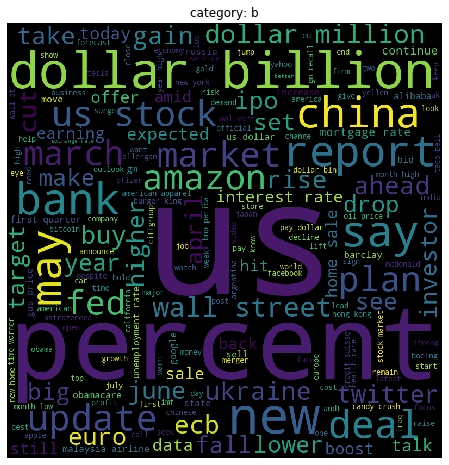

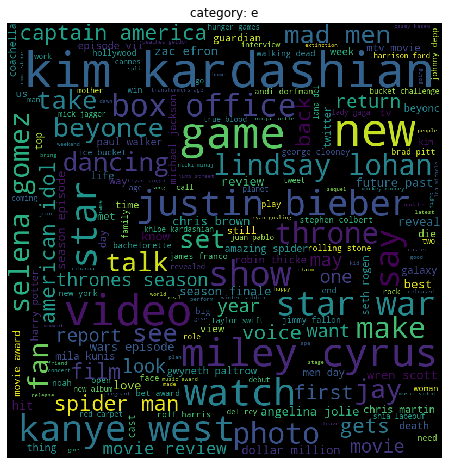

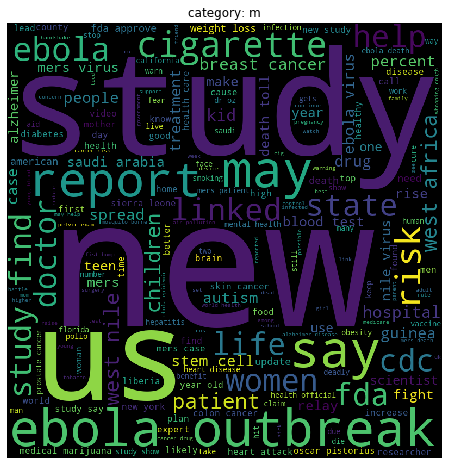

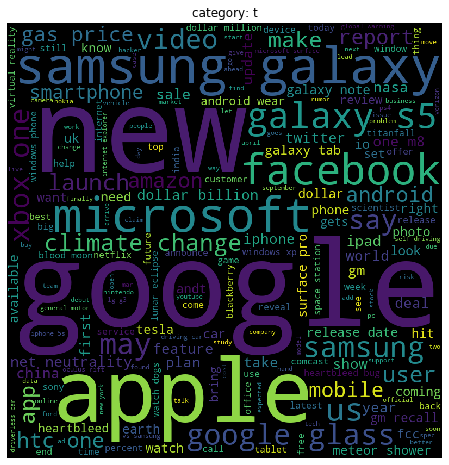

In [30]:
grouped=train_set.groupby(by="CATEGORY")

for category in grouped.groups.keys():
    plt.figure(figsize=(8,8))
    cloud=WordCloud(width=800,height=800, background_color="black", stopwords=my_stopwords,
                    min_font_size=10, random_state=2021).generate(" ".join(grouped.get_group(category)["TITLE_clean"]))
    
    plt.imshow(cloud)
    plt.title('category: {}'.format(category))
    plt.axis('off')
    plt.show()

words "new", "us", "may" and "say" should be deleted, they are in all the categories

In [31]:
# stoplist update
my_stopwords=my_stopwords.union({"new", "us", "may", "say"})

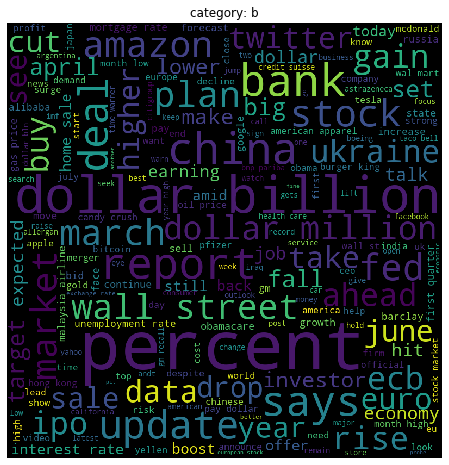

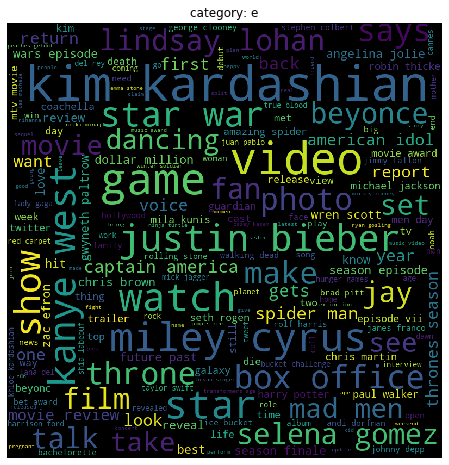

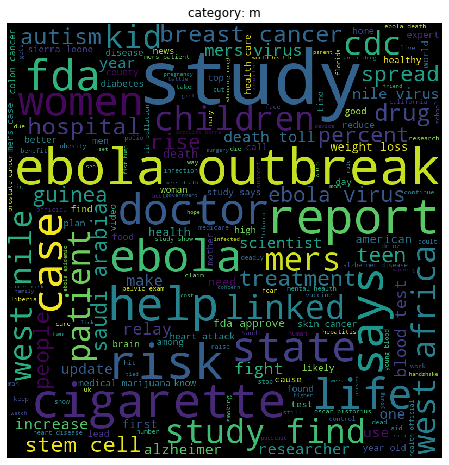

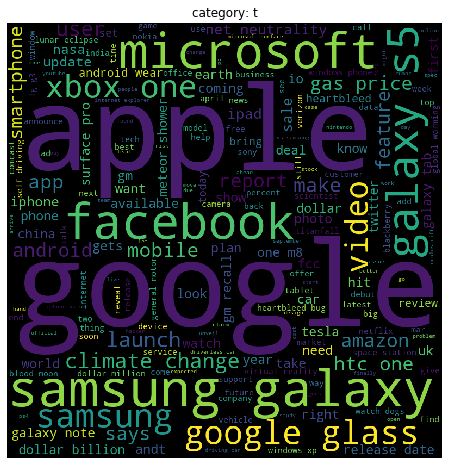

In [32]:
grouped=train_set.groupby(by="CATEGORY")

for category in grouped.groups.keys():
    plt.figure(figsize=(8,8))
    cloud=WordCloud(width=800,height=800, background_color="black", stopwords=my_stopwords,
                    min_font_size=10, random_state=2021).generate(" ".join(grouped.get_group(category)["TITLE_clean"]))
    
    plt.imshow(cloud)
    plt.title('category: {}'.format(category))
    plt.axis('off')
    plt.show()

Results are much better now, there are more different words in the clouds. Token column has to be updated.

In [34]:
# tokenization for train set
train_set["tokens_no_stopwords"]=train_set.tokens.apply(
    lambda tokens: [token for token in tokens if token not in my_stopwords])

# tokenization for validation set
val_set["tokens_no_stopwords"]=val_set.tokens.apply(
    lambda tokens: [token for token in tokens if token not in my_stopwords])

# tokenization for test set
test_set["tokens_no_stopwords"]=test_set.tokens.apply(
    lambda tokens: [token for token in tokens if token not in my_stopwords])

In [35]:
# How the data looks now?
train_set.head()

TITLE CATEGORY  \
400178         Fist Bump vs. Hand Shake: Which Is Better?        m   
308819            HTC's 9-inch Nexus tablet leaked online        t   
3323    Neil Young's PonoPlayer delivers studio-qualit...        e   
403854  5 SECONDS OF SUMMER Announce 'Rock Out With Yo...        e   
168219  Ticket information for rescheduled Miley Cyrus...        e   

                                              TITLE_clean  \
400178            fist bump vs hand shake which is better   
308819              htc 9 inch nexus tablet leaked online   
3323    neil young ponoplayer delivers studio quality ...   
403854  5 seconds of summer announce rock out with you...   
168219  ticket information for rescheduled miley cyrus...   

                                                   tokens  \
400178   [fist, bump, vs, hand, shake, which, is, better]   
308819      [htc, 9, inch, nexus, tablet, leaked, online]   
3323    [neil, young, ponoplayer, delivers, studio, qu...   
403854  [5, seconds, of, summer, announce, rock, out, ...   
168219  [ticket, information, for, rescheduled, miley,...   

                                      tokens_no_stopwords  
400178              [fist, bump, vs, hand, shake, better]  
308819      [htc, 9, inch, nexus, tablet, leaked, online]  
3323    [neil, young, ponoplayer, delivers, studio, qu...  
403854  [5, seconds, summer, announce, rock, socks, 2015]  
168219  [ticket, information, rescheduled, miley, cyru...

#### Lemmatization
In this subsection two lemmatization models (WordNetLemmatizer and SpaCy) are tested and the better one was chosen.

In [36]:
# WordNetLemmatizer
lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()

In [37]:
# WordNetLemmatizer performance on several examples
for i in range(10):
    print("\ni:",i)
    tokens=train_set.tokens_no_stopwords.iloc[i]
    print(tokens)
    print([lemmatizer.lemmatize(token) for token in tokens])


i: 0
['fist', 'bump', 'vs', 'hand', 'shake', 'better']
['fist', 'bump', 'v', 'hand', 'shake', 'better']

i: 1
['htc', '9', 'inch', 'nexus', 'tablet', 'leaked', 'online']
['htc', '9', 'inch', 'nexus', 'tablet', 'leaked', 'online']

i: 2
['neil', 'young', 'ponoplayer', 'delivers', 'studio', 'quality', 'sound']
['neil', 'young', 'ponoplayer', 'delivers', 'studio', 'quality', 'sound']

i: 3
['5', 'seconds', 'summer', 'announce', 'rock', 'socks', '2015']
['5', 'second', 'summer', 'announce', 'rock', 'sock', '2015']

i: 4
['ticket', 'information', 'rescheduled', 'miley', 'cyrus', 'show', 'released']
['ticket', 'information', 'rescheduled', 'miley', 'cyrus', 'show', 'released']

i: 5
['google', 'chromecast', 'hits', 'uk']
['google', 'chromecast', 'hit', 'uk']

i: 6
['frontback', 'dual', 'camera', 'app', 'available', 'android']
['frontback', 'dual', 'camera', 'app', 'available', 'android']

i: 7
['health', 'care', 'law', 'obstacles', 'clear']
['health', 'care', 'law', 'obstacle', 'clear']

i:

Not a great job, "vs" is lemmatized while verbs are not. SpaCy below.

In [38]:
# SpaCy loading
spacy_model=spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# SpaCy performance on several examples
for i in range(10):
    print("\ni:",i)
    doc=spacy_model(" ".join(train_set.tokens_no_stopwords.iloc[i]))
    print(train_set.tokens_no_stopwords.iloc[i])
    print([token.lemma_ for token in doc])


i: 0
['fist', 'bump', 'vs', 'hand', 'shake', 'better']
['fist', 'bump', 'vs', 'hand', 'shake', 'well']

i: 1
['htc', '9', 'inch', 'nexus', 'tablet', 'leaked', 'online']
['htc', '9', 'inch', 'nexus', 'tablet', 'leak', 'online']

i: 2
['neil', 'young', 'ponoplayer', 'delivers', 'studio', 'quality', 'sound']
['neil', 'young', 'ponoplayer', 'deliver', 'studio', 'quality', 'sound']

i: 3
['5', 'seconds', 'summer', 'announce', 'rock', 'socks', '2015']
['5', 'second', 'summer', 'announce', 'rock', 'sock', '2015']

i: 4
['ticket', 'information', 'rescheduled', 'miley', 'cyrus', 'show', 'released']
['ticket', 'information', 'reschedule', 'miley', 'cyrus', 'show', 'release']

i: 5
['google', 'chromecast', 'hits', 'uk']
['google', 'chromecast', 'hit', 'uk']

i: 6
['frontback', 'dual', 'camera', 'app', 'available', 'android']
['frontback', 'dual', 'camera', 'app', 'available', 'android']

i: 7
['health', 'care', 'law', 'obstacles', 'clear']
['health', 'care', 'law', 'obstacle', 'clear']

i: 8
['m

SpaCy lemmatizer works much better<br>
Expected execution time is estimated before the aplication on the whole dataset.

In [39]:
# delete unnecessary variable
del lemmatizer

In [40]:
start=timer()
spacy_model(" ".join(train_set.tokens_no_stopwords.iloc[0]))
end=timer()
runtime=end-start
print("one example takes: {} seconds".format(runtime))
print("whole dataset takes: {} minutes".format(runtime*train_set.shape[0]/60))

one example takes: 0.0036039000000300803 seconds
whole dataset takes: 18.762984570156608 minutes


In [41]:
# creating spacy docs for train set
start=timer()
train_set["spacy_docs"]=train_set.tokens_no_stopwords.apply(
    lambda x: spacy_model(" ".join(x)))
end=timer()
runtime=end-start
print("execution time: {} minutes".format(runtime/60))

# creating spacy docs for validation set
start=timer()
val_set["spacy_docs"]=val_set.tokens_no_stopwords.apply(
    lambda x: spacy_model(" ".join(x)))
end=timer()
runtime=end-start
print("execution time: {} minutes".format(runtime/60))

# creating spacy docs for test set
start=timer()
test_set["spacy_docs"]=test_set.tokens_no_stopwords.apply(
    lambda x: spacy_model(" ".join(x)))
end=timer()
runtime=end-start
print("execution time: {} minutes".format(runtime/60))

execution time: 10.138223948333332 minutes
execution time: 1.7182092100000015 minutes
execution time: 1.7056510066666646 minutes


time estimation quality was pretty poor :) lemmatization below.

In [45]:
# another poor execution time estimation :)
start=timer()
[token.lemma_ for token in train_set["spacy_docs"].iloc[0]]
end=timer()
runtime=end-start
print("one example takes: {} seconds".format(runtime))
print("whole dataset takes: {} minutes".format(runtime*train_set.shape[0]/60))

one example takes: 0.0001475999999911437 seconds
whole dataset takes: 0.7684498799538915 minutes


In [46]:
# train set lemmatization
train_set["tokens_cl_nosw_lemma"]=train_set.spacy_docs.apply(lambda tokens: [token.lemma_ for token in tokens])

# validation set lemmatization
val_set["tokens_cl_nosw_lemma"]=val_set.spacy_docs.apply(lambda tokens: [token.lemma_ for token in tokens])

# test set lemmatization
test_set["tokens_cl_nosw_lemma"]=test_set.spacy_docs.apply(lambda tokens: [token.lemma_ for token in tokens])

Data changes now, words clouds check below.

In [47]:
# train set converting tokens to texts
train_set["TITLE_cl_nosw_lemma"]=train_set.tokens_cl_nosw_lemma.apply(lambda tokens: " ".join(tokens))

# validation set converting tokens to texts
val_set["TITLE_cl_nosw_lemma"]=val_set.tokens_cl_nosw_lemma.apply(lambda tokens: " ".join(tokens))

# test set converting tokens to texts
test_set["TITLE_cl_nosw_lemma"]=test_set.tokens_cl_nosw_lemma.apply(lambda tokens: " ".join(tokens))

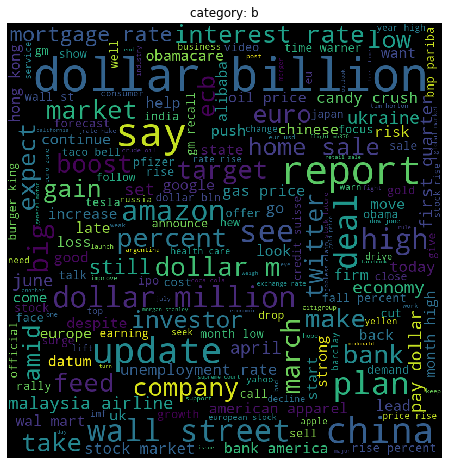

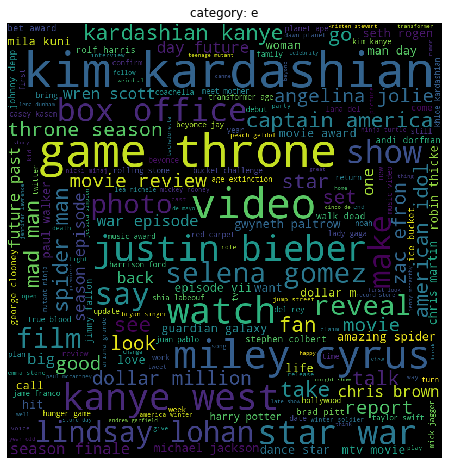

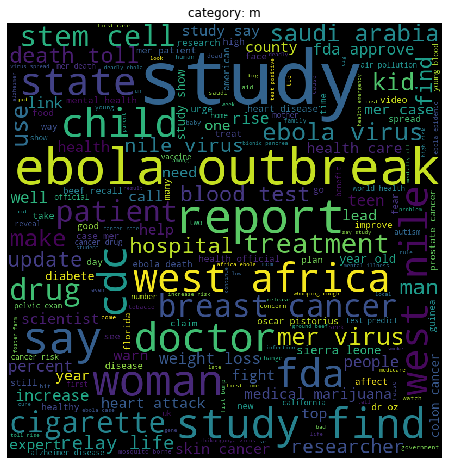

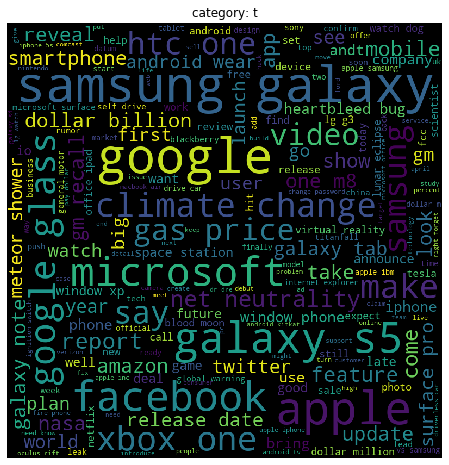

In [48]:
grouped=train_set.groupby(by="CATEGORY")

for category in grouped.groups.keys():
    plt.figure(figsize=(8,8))
    cloud=WordCloud(width=800,height=800, background_color="black", stopwords=None,
                    min_font_size=10, random_state=2021).generate(" ".join(grouped.get_group(category)["TITLE_cl_nosw_lemma"]))
    
    plt.imshow(cloud)
    plt.title('category: {}'.format(category))
    plt.axis('off')
    plt.show()

Word clouds change a bit, but what is very important to notice, after lemmatization some words was converted to the ones from the stoplist, so it is important to remove stopwords again 

In [49]:
# train set stopwords removing again
train_set["tokens_cl_nosw_lemma_nosw"]=train_set.tokens_cl_nosw_lemma.apply(
    lambda tokens: [token for token in tokens if token not in my_stopwords])
train_set["TITLE_cl_nosw_lemma_nosw"]=train_set.tokens_cl_nosw_lemma_nosw.apply(
    lambda tokens: " ".join(tokens))

# validation set stopwords removing again
val_set["tokens_cl_nosw_lemma_nosw"]=val_set.tokens_cl_nosw_lemma.apply(
    lambda tokens: [token for token in tokens if token not in my_stopwords])
val_set["TITLE_cl_nosw_lemma_nosw"]=val_set.tokens_cl_nosw_lemma_nosw.apply(
    lambda tokens: " ".join(tokens))

# test set stopwords removing again
test_set["tokens_cl_nosw_lemma_nosw"]=test_set.tokens_cl_nosw_lemma.apply(
    lambda tokens: [token for token in tokens if token not in my_stopwords])
test_set["TITLE_cl_nosw_lemma_nosw"]=test_set.tokens_cl_nosw_lemma_nosw.apply(
    lambda tokens: " ".join(tokens))

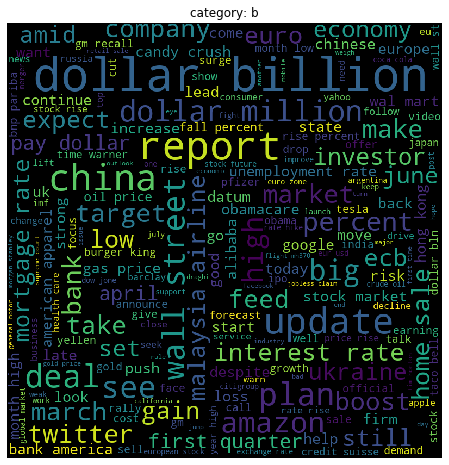

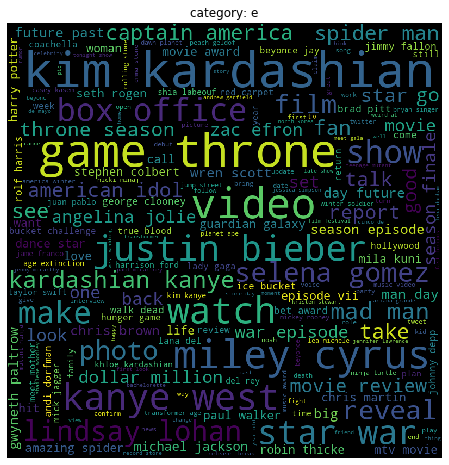

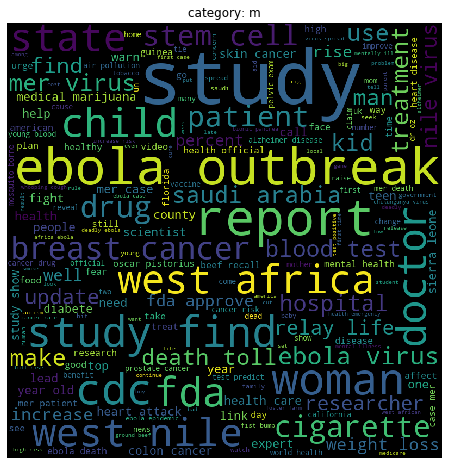

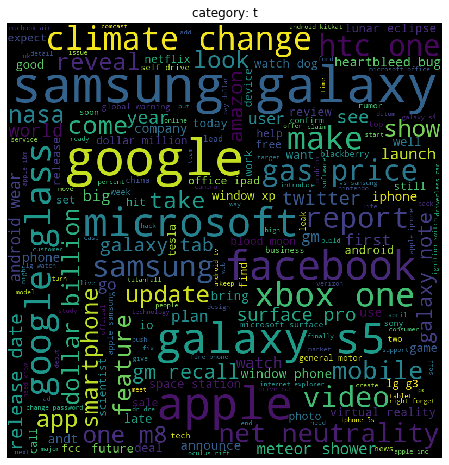

In [50]:
grouped=train_set.groupby(by="CATEGORY")

for category in grouped.groups.keys():
    plt.figure(figsize=(8,8))
    cloud=WordCloud(width=800,height=800, background_color="black", stopwords=None,
                    min_font_size=10, random_state=2021).generate(" ".join(grouped.get_group(category)["TITLE_cl_nosw_lemma_nosw"]))
    
    plt.imshow(cloud)
    plt.title('category: {}'.format(category))
    plt.axis('off')
    plt.show()

much better now.<br>
Now, the data are ready for CNN layer<br>

#### Feature engineering
ideas:
 - original titles length
 - fully preprocessed titles length
 - mean of the words lengths in the preprocessed title
 - sentiment
 - name entity recognition to extract persons and organizations
 - n-grams: ebola outbreak or climate change for example

In [51]:
# titles lengths

# train set new features
train_set["org_length"]=train_set.tokens.apply(lambda sentence: len(sentence))
train_set["proc_length"]=train_set.tokens_cl_nosw_lemma_nosw.apply(lambda sentence: len(sentence))
train_set["mean_words_len_proc"]=train_set.tokens_cl_nosw_lemma_nosw.apply(
    lambda tokens: np.mean([len(token) for token in tokens]))

# validation set new features
val_set["org_length"]=val_set.tokens.apply(lambda sentence: len(sentence))
val_set["proc_length"]=val_set.tokens_cl_nosw_lemma_nosw.apply(lambda sentence: len(sentence))
val_set["mean_words_len_proc"]=val_set.tokens_cl_nosw_lemma_nosw.apply(
    lambda tokens: np.mean([len(token) for token in tokens]))

# test set new features
test_set["org_length"]=test_set.tokens.apply(lambda sentence: len(sentence))
test_set["proc_length"]=test_set.tokens_cl_nosw_lemma_nosw.apply(lambda sentence: len(sentence))
test_set["mean_words_len_proc"]=test_set.tokens_cl_nosw_lemma_nosw.apply(
    lambda tokens: np.mean([len(token) for token in tokens]))

C:\Users\maciej\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


interesting warning, lets check for empty titles (could occur when base title consist stopwords only)

In [52]:
train_set[train_set.proc_length==0]

TITLE CATEGORY                 TITLE_clean  \
69612                     'If/Then'        e                     if then   
270969                  What the...        e                    what the   
21765                        How-To        t                      how to   
69212                     What's Up        e                     what up   
104741  As They Do, Not As They Say        b  as they do not as they say   
205040            You May Also Like        t           you may also like   
407600                    Get On Up        e                   get on up   
220989              We are OVER IT!        e              we are over it   
199794             R,G and all that        b                and all that   
201579                    M is for…        e                      is for   
269428                 You are here        e                you are here   
273343              I don't get it!        t               do not get it   
402672                  'Get On Up'        e                   get on up   
63588                Who Said That?        m               who said that   
377545                  That's all?        b                 that is all   
407615     How 'Get On Up' got done        e      how get on up got done   

                                    tokens tokens_no_stopwords   spacy_docs  \
69612                           [if, then]                  []           ()   
270969                         [what, the]                  []           ()   
21765                            [how, to]                  []           ()   
69212                           [what, up]                  []           ()   
104741  [as, they, do, not, as, they, say]                  []           ()   
205040              [you, may, also, like]                  []           ()   
407600                       [get, on, up]                  []           ()   
220989                 [we, are, over, it]                  []           ()   
199794                    [and, all, that]                  []           ()   
201579                           [is, for]                  []           ()   
269428                    [you, are, here]                  []           ()   
273343                  [do, not, get, it]                  []           ()   
402672                       [get, on, up]                  []           ()   
63588                    [who, said, that]              [said]       (said)   
377545                     [that, is, all]                  []           ()   
407615       [how, get, on, up, got, done]         [got, done]  (got, done)   

       tokens_cl_nosw_lemma TITLE_cl_nosw_lemma tokens_cl_nosw_lemma_nosw  \
69612                    []                                            []   
270969                   []                                            []   
21765                    []                                            []   
69212                    []                                            []   
104741                   []                                            []   
205040                   []                                            []   
407600                   []                                            []   
220989                   []                                            []   
199794                   []                                            []   
201579                   []                                            []   
269428                   []                                            []   
273343                   []                                            []   
402672                   []                                            []   
63588                 [say]                 say                        []   
377545                   []                                            []   
407615            [get, do]              get do                        []   

       TITLE_cl_nosw_lemma_nosw  org_length  proc_length  mean_words_len_proc  
696

These observations can be treated as outliers and deleted

In [53]:
print("Number of nans in the train set:",train_set.shape[0]-train_set.dropna().shape[0])

Number of nans in the train set: 16


In [54]:
# removing nans
train_set.dropna(inplace=True)
val_set.dropna(inplace=True)
test_set.dropna(inplace=True)

Number of outliers (longer than 100 words)

In [55]:
print("number of outliers in train set:",train_set[train_set.org_length>100].shape[0])
print("number of outliers in validation set:",val_set[val_set.org_length>100].shape[0])
print("number of outliers in test set:",test_set[test_set.org_length>100].shape[0])

number of outliers in train set: 8
number of outliers in validation set: 1
number of outliers in test set: 0


In [56]:
# How the outliers looks like?
train_set[train_set.org_length>100]

TITLE CATEGORY  \
279114  The Fault In Our Stars' to release in India on...        e   
194882  I never thought I'd be in love” says Angelina ...        e   
69473   Love & Hip-Hop' Star Benzino Shot By Nephew En...        e   
98518   I don't know why I'm a sex symbol' says smould...        e   
112847  A few years ago, scientists calculated that be...        t   
110870  Hunger Games' top winner at MTV Movie Awards\t...        e   
210277  The Best Reactions To The Supposed Video of So...        e   
391520  More Japanese Xbox One Games In Development, A...        t   

                                              TITLE_clean  \
279114  the fault in our stars to release in india on ...   
194882  never thought would be in love says angelina j...   
69473   love and hip hop star benzino shot by nephew e...   
98518   do not know why am sex symbol says smouldering...   
112847  few years ago scientists calculated that benef...   
110870  hunger games top winner at mtv movie awards ht...   
210277  the best reactions to the supposed video of so...   
391520  more japanese xbox one games in development ap...   

                                                   tokens  \
279114  [the, fault, in, our, stars, to, release, in, ...   
194882  [never, thought, would, be, in, love, says, an...   
69473   [love, and, hip, hop, star, benzino, shot, by,...   
98518   [do, not, know, why, am, sex, symbol, says, sm...   
112847  [few, years, ago, scientists, calculated, that...   
110870  [hunger, games, top, winner, at, mtv, movie, a...   
210277  [the, best, reactions, to, the, supposed, vide...   
391520  [more, japanese, xbox, one, games, in, develop...   

                                      tokens_no_stopwords  \
279114  [fault, stars, release, india, july, 4, sahara...   
194882  [never, thought, love, says, angelina, jolie, ...   
69473   [love, hip, hop, star, benzino, shot, nephew, ...   
98518   [know, sex, symbol, says, smouldering, hunk, m...   
112847  [years, ago, scientists, calculated, benefit, ...   
110870  [hunger, games, top, winner, mtv, movie, award...   
210277  [best, reactions, supposed, video, solange, kn...   
391520  [japanese, xbox, one, games, development, appl...   

                                               spacy_docs  \
279114  (fault, stars, release, india, july, 4, sahara...   
194882  (never, thought, love, says, angelina, jolie, ...   
69473   (love, hip, hop, star, benzino, shot, nephew, ...   
98518   (know, sex, symbol, says, smouldering, hunk, m...   
112847  (years, ago, scientists, calculated, benefit, ...   
110870  (hunger, games, top, winner, mtv, movie, award...   
210277  (best, reactions, supposed, video, solange, kn...   
391520  (japanese, xbox, one, games, development, appl...   

                                     tokens_cl_nosw_lemma  \
279114  [fault, star, release, india, july, 4, saharas...   
194882  [never, think, love, say, angelina, jolie, sha...   
69473   [love, hip, hop, star, benzino, shoot, nephew,...   
98518   [know, sex, symbol, say, smoulder, hunk, manli...   
112847  [year, ago, scientist, calculate, benefit, net...   
110870  [hunger, game, top, winner, mtv, movie, award,...   
210277  [good, reaction, suppose, video, solange, know...   
391520  [japanese, xbox, one, game, development, appli...   

                                      TITLE_cl_nosw_lemma  \
279114  fault star release india july 4 saharasamay en...   
194882  never think love say angelina jolie shanghaida...   
69473   love hip hop star benzino shoot nephew en rout...   
98518   know sex symbol say smoulder hunk manliness jo...   
112847  year ago scientist calculate benefit net prese...   
110870  hunger game top winner mtv movie award tuscalo...   
210277  good reaction suppose video solange knowle jay...   
391520  japanese xbox one game development application...   

                                tokens_cl_nosw_lemma_nosw  \
279114  [fault, star, release, india, july, 4, saharas...   

In [57]:
# How one of the outliers looks like?
train_set.loc[112847, "TITLE"]

'A few years ago, scientists calculated that benefit as having a net present value  ...\thttp://theenergycollective.com/josephromm/367921/climate-panel-stunner-avoiding-climate-catastrophe-super-cheap-only-if-we-act-now\tEnergy Collective\tt\tdPhzj-Zymt7_2fMuSkTFhziYo3U0M\ttheenergycollective.com\t1397513703600\n113084\tTime Is Running Out … and Five Other Takeaways From the UN\'s Global  ...\thttp://www.nationaljournal.com/energy/time-is-running-out-and-five-other-takeaways-from-the-u-n-s-global-warming-report-20140414\tNational Journal\tt\tdPhzj-Zymt7_2fMuSkTFhziYo3U0M\twww.nationaljournal.com\t1397513703854\n113085\tStep up action to curb global warming, or risks rise: UN\thttp://www.reuters.com/article/2014/04/13/us-climatechange-un-idUSBREA3C06020140413\tReuters\tt\tdPhzj-Zymt7_2fMuSkTFhziYo3U0M\twww.reuters.com\t1397513704071\n113086\tDire UN Climate Reports Raise Questions About Global Willpower\thttp://news.nationalgeographic.com/news/2014/04/140414-ipcc-impacts-future-climate-

These outliers should be deleted

In [58]:
# train set outliers removing
train_set.drop(labels=train_set[train_set.org_length>100].index.tolist(), axis=0, inplace=True)
print(train_set[train_set.org_length>100].index)

# validation set outliers removing
val_set.drop(labels=val_set[val_set.org_length>100].index.tolist(), axis=0, inplace=True)
print(val_set[val_set.org_length>100].index)

Int64Index([], dtype='int64')
Int64Index([], dtype='int64')


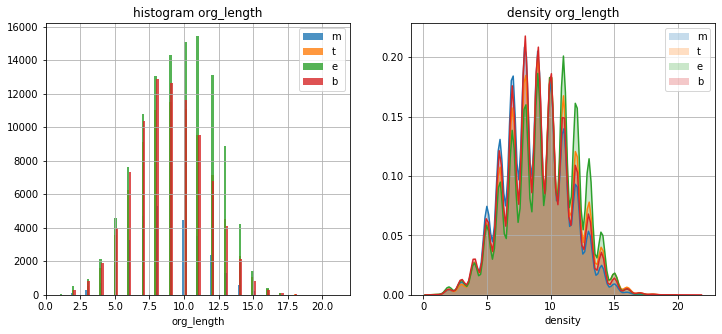

In [59]:
# Created features analysis

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,5))
for category in train_set.CATEGORY.unique():
    sns.distplot(train_set[train_set.CATEGORY==category]["org_length"], hist=True, kde=False, hist_kws={"alpha":0.8}, 
                 ax=ax[0], bins=100)
    
    sns.distplot(train_set[train_set.CATEGORY==category]["org_length"], hist=False, kde=True, kde_kws={"shade":True},
                axlabel="density", ax=ax[1])
    ax[0].grid(True)
    ax[1].grid(True)
    ax[0].legend(train_set.CATEGORY.unique())
    ax[1].legend(train_set.CATEGORY.unique())
    ax[0].set_title("histogram org_length")
    ax[1].set_title("density org_length")
plt.show()

Normalziation is needed, formula:

$$z=\frac{x-\mu}{\sigma}$$

where:<br>
   x is observation<br>
   $\mu$ is mean<br>
   $\sigma$ is standard deviation
   
Note: validation and test set are normalized with train set characteristics to prevent data leakage.

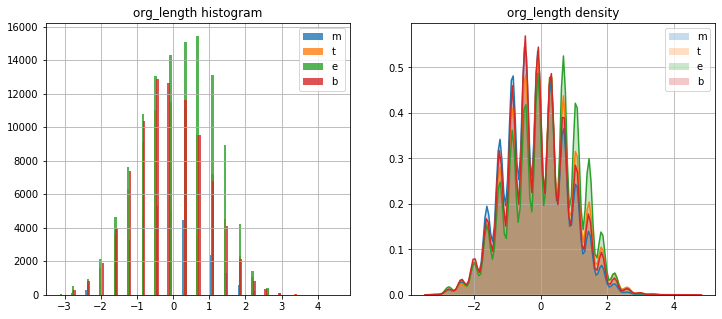

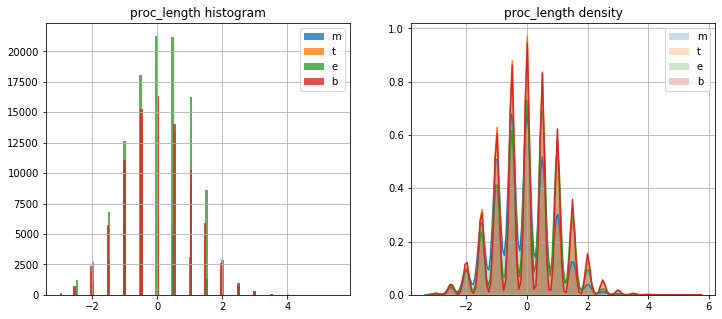

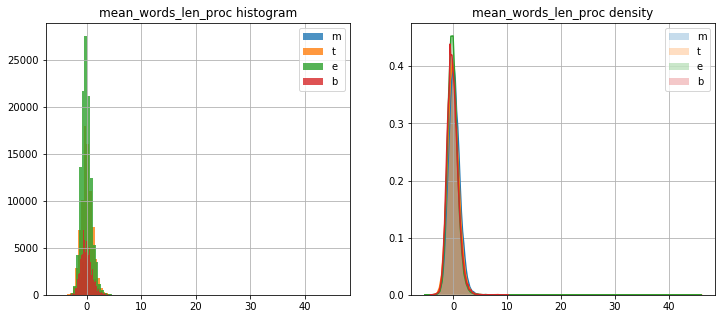

In [60]:
to_norm=["org_length", "proc_length", "mean_words_len_proc"]
# normalized train set
normalized=(train_set.loc[:,to_norm]-train_set.loc[:,to_norm].mean(axis=0))/train_set.loc[:,to_norm].std(axis=0)
# normalized validation set using train set characteristics
normalized_val=(val_set.loc[:,to_norm]-train_set.loc[:,to_norm].mean(axis=0))/train_set.loc[:,to_norm].std(axis=0)
# normalized test set using train set characteristics
normalized_test=(test_set.loc[:,to_norm]-train_set.loc[:,to_norm].mean(axis=0))/train_set.loc[:,to_norm].std(axis=0)


for feature in to_norm:
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,5))
    for category in train_set.CATEGORY.unique():
        sns.distplot(normalized[train_set.CATEGORY==category][feature], hist=True, kde=False, hist_kws={"alpha":0.8}, 
                     ax=ax[0], bins=100)

        sns.distplot(normalized[train_set.CATEGORY==category][feature], hist=False, kde=True, kde_kws={"shade":True}, 
                     ax=ax[1])
        ax[0].grid(True)
        ax[1].grid(True)
        ax[0].legend(train_set.CATEGORY.unique())
        ax[1].legend(train_set.CATEGORY.unique())
        ax[0].set_title("{} histogram".format(feature))
        ax[1].set_title("{} density".format(feature))
        ax[0].xaxis.label.set_visible(False)
        ax[1].xaxis.label.set_visible(False)
    plt.show()

org_length and proc_lenght are a little bit different, mean_words_len_proc is not, the first two normalized features will be saved in dataframe

In [61]:
# saving normalized features and deleting the unnecessary one train set
train_set.loc[:,["org_length", "proc_length"]]=normalized.iloc[:,0:2]
train_set.drop(labels="mean_words_len_proc", axis=1, inplace=True)

# saving normalized features and deleting the unnecessary one validation set
val_set.loc[:,["org_length", "proc_length"]]=normalized_val.iloc[:,0:2]
val_set.drop(labels="mean_words_len_proc", axis=1, inplace=True)

# saving normalized features and deleting the unnecessary one test set
test_set.loc[:,["org_length", "proc_length"]]=normalized_test.iloc[:,0:2]
test_set.drop(labels="mean_words_len_proc", axis=1, inplace=True)

In [63]:
# delete unnecessary variables
del normalized
del normalized_test
del normalized_val

In [62]:
# How the data looks now?
train_set.head()

TITLE CATEGORY  \
400178         Fist Bump vs. Hand Shake: Which Is Better?        m   
308819            HTC's 9-inch Nexus tablet leaked online        t   
3323    Neil Young's PonoPlayer delivers studio-qualit...        e   
403854  5 SECONDS OF SUMMER Announce 'Rock Out With Yo...        e   
168219  Ticket information for rescheduled Miley Cyrus...        e   

                                              TITLE_clean  \
400178            fist bump vs hand shake which is better   
308819              htc 9 inch nexus tablet leaked online   
3323    neil young ponoplayer delivers studio quality ...   
403854  5 seconds of summer announce rock out with you...   
168219  ticket information for rescheduled miley cyrus...   

                                                   tokens  \
400178   [fist, bump, vs, hand, shake, which, is, better]   
308819      [htc, 9, inch, nexus, tablet, leaked, online]   
3323    [neil, young, ponoplayer, delivers, studio, qu...   
403854  [5, seconds, of, summer, announce, rock, out, ...   
168219  [ticket, information, for, rescheduled, miley,...   

                                      tokens_no_stopwords  \
400178              [fist, bump, vs, hand, shake, better]   
308819      [htc, 9, inch, nexus, tablet, leaked, online]   
3323    [neil, young, ponoplayer, delivers, studio, qu...   
403854  [5, seconds, summer, announce, rock, socks, 2015]   
168219  [ticket, information, rescheduled, miley, cyru...   

                                               spacy_docs  \
400178              (fist, bump, vs, hand, shake, better)   
308819      (htc, 9, inch, nexus, tablet, leaked, online)   
3323    (neil, young, ponoplayer, delivers, studio, qu...   
403854  (5, seconds, summer, announce, rock, socks, 2015)   
168219  (ticket, information, rescheduled, miley, cyru...   

                                     tokens_cl_nosw_lemma  \
400178                [fist, bump, vs, hand, shake, well]   
308819        [htc, 9, inch, nexus, tablet, leak, online]   
3323    [neil, young, ponoplayer, deliver, studio, qua...   
403854    [5, second, summer, announce, rock, sock, 2015]   
168219  [ticket, information, reschedule, miley, cyrus...   

                                      TITLE_cl_nosw_lemma  \
400178                       fist bump vs hand shake well   
308819                htc 9 inch nexus tablet leak online   
3323    neil young ponoplayer deliver studio quality s...   
403854            5 second summer announce rock sock 2015   
168219  ticket information reschedule miley cyrus show...   

                                tokens_cl_nosw_lemma_nosw  \
400178                [fist, bump, vs, hand, shake, well]   
308819        [htc, 9, inch, nexus, tablet, leak, online]   
3323    [neil, young, ponoplayer, deliver, studio, qua...   
403854    [5, second, summer, announce, rock, sock, 2015]   
168219  [ticket, information, reschedule, miley, cyrus...   

                                 TITLE_cl_nosw_lemma_nosw  org_length  \
400178                       fist bump vs hand shake well   -0.461423   
308819                htc 9 inch nexus tablet leak online   -0.844108   
3323    neil young ponoplayer deliver studio quality s...   -0.844108   
403854            5 second summer announce rock sock 2015    1.069318   
168219  ticket information reschedule miley cyrus show...   -0.461423   

        proc_length  
400178    -0.499022  
308819     0.001897  
3323       0.001897  
403854     0.001897  
168219     0.001897

#### Sentiment (part of the feature engineering)

Vader sentiment analyzer was chosen for the task, it is semi-supervised method and easy to apply. Sentiment is normalized too (for neural networks better performance)

In [64]:
# Vader loading
vader = SentimentIntensityAnalyzer()

In [65]:
# sentiment computation train set
train_set["sentiment"]=train_set["TITLE_cl_nosw_lemma_nosw"].apply(lambda sentence: vader.polarity_scores(sentence)["compound"])
# sentiment normalziation train set
train_set.sentiment=(train_set.sentiment-train_set.sentiment.mean())/train_set.sentiment.std()

# sentiment computation validation set
val_set["sentiment"]=val_set["TITLE_cl_nosw_lemma_nosw"].apply(lambda sentence: vader.polarity_scores(sentence)["compound"])
# sentiment normalziation validation set using train set characteristics
val_set.sentiment=(val_set.sentiment-train_set.sentiment.mean())/train_set.sentiment.std()

# sentiment computation test set
test_set["sentiment"]=test_set["TITLE_cl_nosw_lemma_nosw"].apply(lambda sentence: vader.polarity_scores(sentence)["compound"])
# sentiment normalziation test set using train set characteristics
test_set.sentiment=(test_set.sentiment-train_set.sentiment.mean())/train_set.sentiment.std()

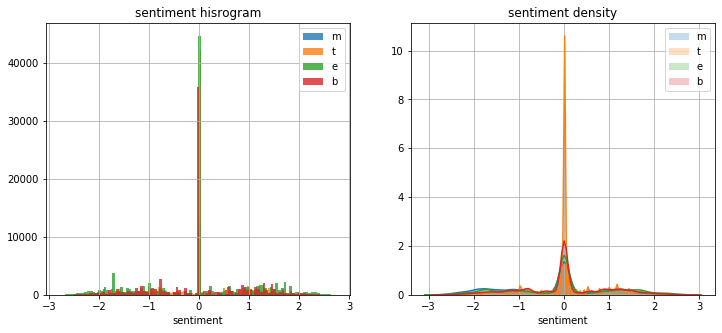

In [66]:
# Sentiment distribution analysis

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,5))
for category in train_set.CATEGORY.unique():
    sns.distplot(train_set[train_set.CATEGORY==category]["sentiment"], hist=True, kde=False, hist_kws={"alpha":0.8}, 
                 ax=ax[0], bins=100)
    
    sns.distplot(train_set[train_set.CATEGORY==category]["sentiment"], hist=False, kde=True, kde_kws={"shade":True},
                ax=ax[1])
    ax[0].grid(True)
    ax[1].grid(True)
    ax[0].legend(train_set.CATEGORY.unique())
    ax[1].legend(train_set.CATEGORY.unique())
    ax[0].set_title("sentiment hisrogram")
    ax[1].set_title("sentiment density")
plt.show()

As expected, technology and science sentiment has the most neutral sentiment what is interesting medical category sentimet's kurtosis is the lowest, this feature seems to be informative.

#### Name entity recognition (part of the feature engineering)
SpaCy model is used again, this time for named entity recognition. NER is used to extract some persons, organizations, places etc. Not only specific tags can be used for as features, number of the entire groups can be used too.

In [68]:
# SpaCy for NER loading
ner=spacy.load("en_core_web_sm")

In [70]:
# SpaCy performance evaluation on the random sample
ner_sample=train_set.TITLE.sample(n=10, random_state=2003)
for i in range(ner_sample.shape[0]):
    spacy.displacy.render(ner(ner_sample.iloc[i]), style="ent")

It is not perfect, but can help, Selena Gomez and Justin Bieber are correctly identified. NER should be performed on the raw data, so spacy_docs has to be prepared again (there is spacy_docs column for tokens without stopwords in the data set already)

In [71]:
start=timer()
ner(train_set.TITLE.iloc[0])
end=timer()
runtime=end-start
print("one example takes: {} seconds".format(runtime))
print("whole dataset takes: {} minutes".format(runtime*train_set.shape[0]/60))

one example takes: 0.007948899999973946 seconds
whole dataset takes: 41.38117850986437 minutes


In [72]:
# train set preparation for named entity recognition
start=timer()
train_set["ner_docs"]=train_set.TITLE.apply(lambda sentence: ner(sentence))
end=timer()
runtime=end-start
print("execution time: {} minutes".format(runtime/60))

# validation set preparation for named entity recognition
start=timer()
val_set["ner_docs"]=val_set.TITLE.apply(lambda sentence: ner(sentence))
end=timer()
runtime=end-start
print("execution time: {} minutes".format(runtime/60))

# test set preparation for named entity recognition
start=timer()
test_set["ner_docs"]=test_set.TITLE.apply(lambda sentence: ner(sentence))
end=timer()
runtime=end-start
print("execution time: {} minutes".format(runtime/60))

execution time: 26.00666936333333 minutes
execution time: 4.45603706333333 minutes
execution time: 4.455075676666668 minutes


In [73]:
# create tuples of tags for train set 
train_set["tags"]=train_set.ner_docs.apply(lambda doc: [(tag.text, tag.label_) for tag in doc.ents])

# create tuples of tags for validation set 
val_set["tags"]=val_set.ner_docs.apply(lambda doc: [(tag.text, tag.label_) for tag in doc.ents])

# create tuples of tags for test set 
test_set["tags"]=test_set.ner_docs.apply(lambda doc: [(tag.text, tag.label_) for tag in doc.ents])

In [4]:
def count_tags(list_of_tags):
    '''
    function counts tags for each observation
    to combine with pd.Series.apply(lambda x: list_of_tags(x))
    '''
    
    dict_of_tags={}
    for tag in list_of_tags:
        if tag not in dict_of_tags.keys():
            dict_of_tags[tag]=1
        else:
            dict_of_tags[tag]+=1
    
    return dict_of_tags

In [5]:
def create_columns_for_tags(df, tag_count):
    '''
    function that creates columns for each tag type in the dataset
    df - data
    tag_count - name of column with tag counts
    '''
    set_of_tags=set()
    for index in range(df.shape[0]):
        for tag in list(df[tag_count].iloc[index].keys()):
            set_of_tags.add(tag[1])
            
    list_of_tags=list(set_of_tags)
    for tag in list_of_tags:
        df["tag_"+str(tag)]=np.zeros(df.shape[0])
        
    return df

In [6]:
def extract_number_of_tags(df, tag_count, core):
    '''
    function that fills created with cerate_columns_for_tags() columns
    df - data
    tag_count - name of column with tag counts
    core - core of names for tags columns (tag_), string
    '''
    for index in range(df.shape[0]):
        for tag, count in df[tag_count].iloc[index].items():
            df[core+str(tag[1])].iloc[index]+=count
            
    return df

In [82]:
# counting tags for each observation train set
start=timer()
train_set["tags_count"]=train_set.tags.apply(lambda tag: count_tags(tag))
end=timer()
runtime=end-start
print("execution time: {} seconds".format(runtime))

# counting tags for each observation validation set
start=timer()
val_set["tags_count"]=val_set.tags.apply(lambda tag: count_tags(tag))
end=timer()
runtime=end-start
print("execution time: {} seconds".format(runtime))

# counting tags for each observation test set
start=timer()
test_set["tags_count"]=test_set.tags.apply(lambda tag: count_tags(tag))
end=timer()
runtime=end-start
print("execution time: {} seconds".format(runtime))

execution time: 0.2187948000000688 seconds
execution time: 0.03820640000049025 seconds
execution time: 0.03874089999953867 seconds


In [83]:
# create columns for tag types train set
start=timer()
train_set=create_columns_for_tags(train_set, "tags_count")
end=timer()
runtime=end-start
print("execution time: {} seconds".format(runtime))

# create columns for tag types validation set
start=timer()
val_set=create_columns_for_tags(val_set, "tags_count")
end=timer()
runtime=end-start
print("execution time: {} seconds".format(runtime))

# create columns for tag types test set
start=timer()
test_set=create_columns_for_tags(test_set, "tags_count")
end=timer()
runtime=end-start
print("execution time: {} seconds".format(runtime))

execution time: 2.8214581000002 seconds
execution time: 0.5094014999995125 seconds
execution time: 0.5036595999999918 seconds


In [87]:
# filling created columns for train set
start=timer()
train_set=extract_number_of_tags(train_set, "tags_count", "tag_")
end=timer()
runtime=end-start
print("execution time: {} seconds".format(runtime))

# filling created columns for validation set
start=timer()
val_set=extract_number_of_tags(val_set, "tags_count", "tag_")
end=timer()
runtime=end-start
print("execution time: {} seconds".format(runtime))

# filling created columns for test set
start=timer()
test_set=extract_number_of_tags(test_set, "tags_count", "tag_")
end=timer()
runtime=end-start
print("execution time: {} seconds".format(runtime))

C:\Users\maciej\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


execution time: 150.74621229999957 seconds
execution time: 12.362751800000296 seconds
execution time: 12.272883699999511 seconds


In [92]:
all_tags=[i for i in train_set.columns.tolist() if "tag_" in i]
print("number of different tag types:",len(all_tags))
print(all_tags)

number of different tag types: 18
['tag_CARDINAL', 'tag_LANGUAGE', 'tag_WORK_OF_ART', 'tag_ORDINAL', 'tag_LOC', 'tag_QUANTITY', 'tag_DATE', 'tag_LAW', 'tag_TIME', 'tag_GPE', 'tag_ORG', 'tag_NORP', 'tag_PERCENT', 'tag_PRODUCT', 'tag_MONEY', 'tag_EVENT', 'tag_FAC', 'tag_PERSON']


So there are 18 different groups of tags, Comparison between classes is needed.

In [93]:
# table which measures tag occurance relative to another tags for THIS PARTICULAR category
# Which tag occurs the most often for given category
tags_comparison=pd.DataFrame(data=np.zeros(shape=(18,4)), index=all_tags, columns=train_set.CATEGORY.unique())

for category in tags_comparison.columns.tolist():
    sums_of_tags=train_set[train_set.CATEGORY==category][all_tags].sum()
    tags_comparison[category]=sums_of_tags/sums_of_tags.sum()*100
    
tags_comparison

m          t          e          b
tag_CARDINAL     11.700012   8.409898   5.245007   5.472967
tag_LANGUAGE      0.043494   0.012404   0.036971   0.017724
tag_WORK_OF_ART   0.959985   1.155342   5.174702   0.644704
tag_ORDINAL       2.796073   1.232424   1.355193   0.847051
tag_LOC           2.600348   2.055517   0.658808   1.384673
tag_QUANTITY      0.416304   0.453631   0.052123   0.112989
tag_DATE          6.865913   7.695784   6.005637  10.089284
tag_LAW           0.093202   0.145304   0.108488   0.089358
tag_TIME          0.565428   0.663613   0.643050   0.454173
tag_GPE          22.840810   8.797080   7.062032  18.754016
tag_ORG          31.067479  48.692709  19.678778  37.936357
tag_NORP          3.871008   1.980207   2.509773   4.389599
tag_PERCENT       1.239592   0.567039   0.046062   2.474688
tag_PRODUCT       0.375916   1.816297   0.629716   0.923116
tag_MONEY         1.074935   3.126689   1.022455   5.407980
tag_EVENT         0.354169   0.283520   0.660020   0.222286
tag_FAC           0.379023   0.751327   0.721840   0.311644
tag_PERSON       12.756307  12.161216  48.389345  10.467392

In [94]:
# table with measures PARTICULAR TAGS occurances in ALL CATEGORIES
# Which part of all the tag occurances is for each category
tags_comparison_v2=pd.DataFrame(data=np.zeros(shape=(18,4)), index=all_tags, columns=train_set.CATEGORY.unique())

for category in tags_comparison.columns.tolist():
    sums_of_tags=train_set[train_set.CATEGORY==category][all_tags].sum()
    tags_comparison_v2[category]=sums_of_tags
    
tags_comparison_v2=tags_comparison_v2.T/tags_comparison_v2.sum(axis=1)
tags_comparison_v2=tags_comparison_v2.T

display(tags_comparison_v2)

m         t         e         b
tag_CARDINAL     0.128432  0.323705  0.295127  0.252737
tag_LANGUAGE     0.123894  0.123894  0.539823  0.212389
tag_WORK_OF_ART  0.028030  0.118287  0.774492  0.079191
tag_ORDINAL      0.158618  0.245153  0.394078  0.202150
tag_LOC          0.136787  0.379147  0.177643  0.306423
tag_QUANTITY     0.151412  0.578531  0.097175  0.172881
tag_DATE         0.064119  0.252009  0.287492  0.396379
tag_LAW          0.060729  0.331984  0.362348  0.244939
tag_TIME         0.069812  0.287303  0.406981  0.235903
tag_GPE          0.135326  0.182760  0.214475  0.467439
tag_ORG          0.067206  0.369349  0.218210  0.345235
tag_NORP         0.091847  0.164750  0.305248  0.438154
tag_PERCENT      0.089342  0.143305  0.017017  0.750336
tag_PRODUCT      0.027130  0.459641  0.232960  0.280269
tag_MONEY        0.026853  0.273884  0.130927  0.568335
tag_EVENT        0.062500  0.175439  0.597039  0.165022
tag_FAC          0.047232  0.328300  0.461092  0.163376
tag_PERSON       0.036711  0.122722  0.713839  0.126728

tags features look reasonable, there is no point in removing them<br>
Most frequent tags are analyzed below.

In [7]:
def most_frequent_tags(df, tag_count):
    '''
    function that counts tags
    df - data,
    tag_count - name of column where are counted tags for each observation (str)
    
    return dataframe with tags and its number occurances (pd.DataFrame) 
    '''
    tags_dct={}
    for index in range(df.shape[0]):
        for item in df[tag_count].iloc[index].items():
            if item[0][0] not in tags_dct.keys():
                tags_dct[item[0][0]]=item[1]
            else:
                tags_dct[item[0][0]]+=item[1]
                
    tags_df=pd.DataFrame(tags_dct.items(), columns = ["tag", "count"]).sort_values("count", ascending = False)
    
    return tags_df

In [96]:
# most frequent tags for medical news
mft_m=most_frequent_tags(train_set[train_set.CATEGORY=="m"], "tags_count")
# most frequent tags for business news
mft_b=most_frequent_tags(train_set[train_set.CATEGORY=="b"], "tags_count")
# most frequent tags for entertainment news
mft_e=most_frequent_tags(train_set[train_set.CATEGORY=="e"], "tags_count")
# most frequent tags for technology and science news
mft_t=most_frequent_tags(train_set[train_set.CATEGORY=="t"], "tags_count")

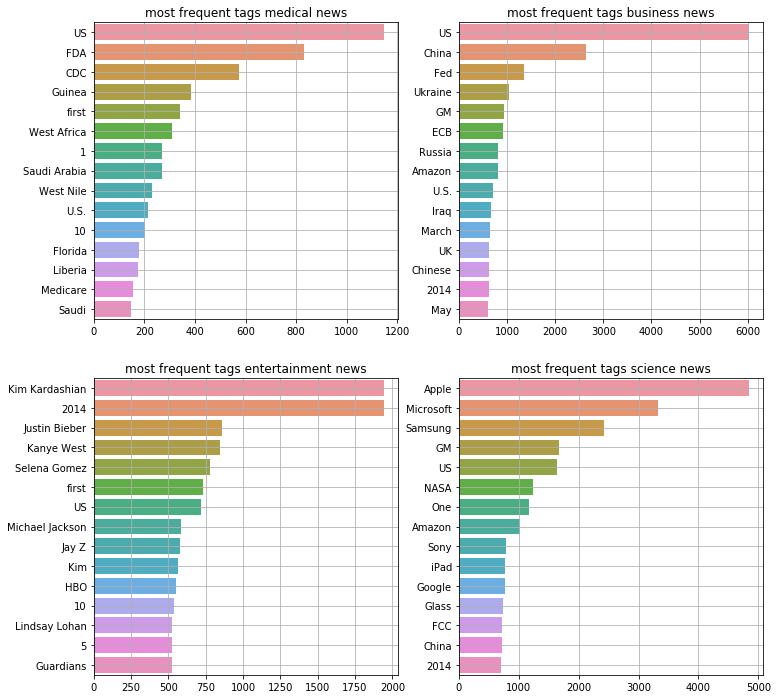

In [97]:
fig,ax=plt.subplots(nrows=2, ncols=2, figsize=(12,12))
sns.barplot(x="count", y="tag", data=mft_m.head(15), ax=ax[0,0])
ax[0,0].set_title("most frequent tags medical news")
ax[0,0].grid(True)
ax[0,0].set_xlabel("")
ax[0,0].set_ylabel("")

sns.barplot(x="count", y="tag", data=mft_b.head(15), ax=ax[0,1])
ax[0,1].set_title("most frequent tags business news")
ax[0,1].grid(True)
ax[0,1].set_xlabel("")
ax[0,1].set_ylabel("")

sns.barplot(x="count", y="tag", data=mft_e.head(15), ax=ax[1,0])
ax[1,0].set_title("most frequent tags entertainment news")
ax[1,0].grid(True)
ax[1,0].set_xlabel("")
ax[1,0].set_ylabel("")

sns.barplot(x="count", y="tag", data=mft_t.head(15), ax=ax[1,1])
ax[1,1].set_title("most frequent tags science news")
ax[1,1].grid(True)
ax[1,1].set_xlabel("")
ax[1,1].set_ylabel("")


plt.show()

There is potential for new features (binary variables):
 - FDA (certificate for medical products)
 - CDC (Centers for Disease Control and Prevention)
 - Guinea
 - China
 - Fed
 - Ukraine
 - GM (General Motors)
 - ECB (European Central Bank)
 - Russia
 - Amazon
 - Kim Kardashian
 - Justin Bieber
 - Kanye West
 - Selena Gomez
 - Michael Jackson
 - Jay Z
 - HBO
 - Lindsay Lohan
 - Guardians
 - Apple
 - Microsoft
 - Samsung
 - Google 
 - NASA
 - Sony
 - FCC
 
another 26 features, computations below

In [98]:
new_tags_features=["FDA", "CDC", "Guinea", "China", "Fed", "Ukraine", "GM", "ECB", "Russia", "Amazon", "Kim Kardashian",
                  "Justin Bieber", "Kanye West", "Selena Gomez", "Michael Jackson", "Jay Z", "HBO", "Lindsay Lohan",
                  "Guardians", "Apple", "Microsoft", "Samsung", "Google", "NASA", "Sony", "FCC"]

# train set
for ntf in new_tags_features:
    col_name=ntf.replace(" ", "_")
    train_set[col_name]=np.zeros(shape=(train_set.shape[0]))
    train_set[col_name][train_set.TITLE.str.contains(ntf)]=1   
    
# validation set
for ntf in new_tags_features:
    col_name=ntf.replace(" ", "_")
    val_set[col_name]=np.zeros(shape=(val_set.shape[0]))
    val_set[col_name][val_set.TITLE.str.contains(ntf)]=1   
    
# test set
for ntf in new_tags_features:
    col_name=ntf.replace(" ", "_")
    test_set[col_name]=np.zeros(shape=(test_set.shape[0]))
    test_set[col_name][test_set.TITLE.str.contains(ntf)]=1   

C:\Users\maciej\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\maciej\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\maciej\anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### n-grams (part of the feature engineering)
In this section bigrams and unigrams frequency is computed to create new features.

In [9]:
def n_grams_frequency(df, tokens, n):
    '''
    function that computes ngrams frequency
    df - data
    tokens - name of column with tokens to compute n_grams frequency (str)
    n - number of words considered for n-gram
    
    return dataframe with n_grams sorted by frequency 
    '''
    
    n_grams_freq=nltk.FreqDist()
    for index in range(df.shape[0]):
        n_grams=nltk.ngrams(sequence=df[tokens].iloc[index], n=n)
        n_grams_freq.update(n_grams)
        
    ngrams_df=pd.DataFrame(n_grams_freq.items(), columns=["n_gram", "count"]).sort_values(by="count", ascending=False)
    
    return ngrams_df

In [108]:
# most frequent bigrams for medical news
bigrams_m=n_grams_frequency(df=train_set[train_set.CATEGORY=="m"], tokens="tokens_cl_nosw_lemma_nosw", n=2)
# most frequent bigrams for business news
bigrams_b=n_grams_frequency(df=train_set[train_set.CATEGORY=="b"], tokens="tokens_cl_nosw_lemma_nosw", n=2)
# most frequent bigrams for entertainment news
bigrams_e=n_grams_frequency(df=train_set[train_set.CATEGORY=="e"], tokens="tokens_cl_nosw_lemma_nosw", n=2)
# most frequent bigrams for technology and science news
bigrams_t=n_grams_frequency(df=train_set[train_set.CATEGORY=="t"], tokens="tokens_cl_nosw_lemma_nosw", n=2)

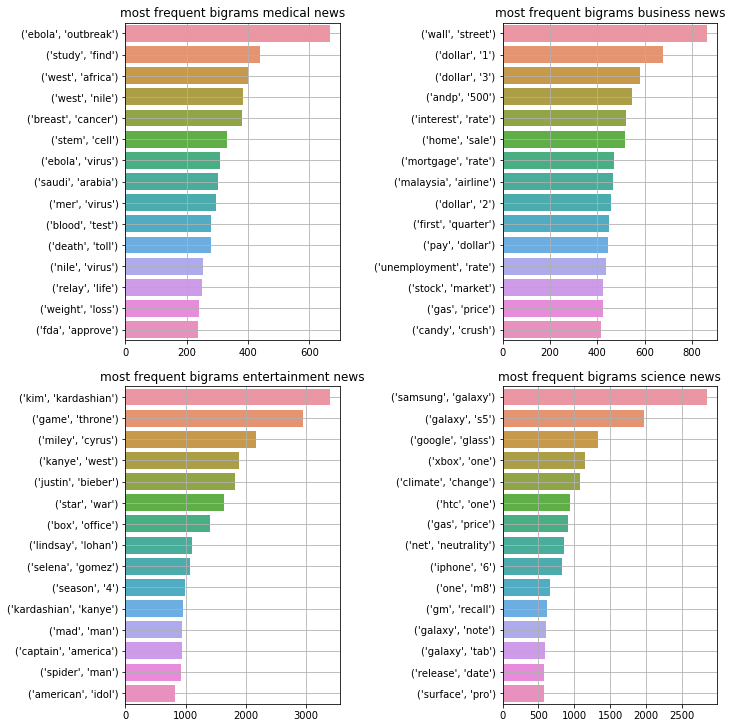

In [109]:
fig,ax=plt.subplots(nrows=2, ncols=2, figsize=(10,10), constrained_layout=True)
sns.barplot(x="count", y="n_gram", data=bigrams_m.head(15), ax=ax[0,0])
ax[0,0].set_title("most frequent bigrams medical news")
ax[0,0].grid(True)
ax[0,0].set_xlabel("")
ax[0,0].set_ylabel("")

sns.barplot(x="count", y="n_gram", data=bigrams_b.head(15), ax=ax[0,1])
ax[0,1].set_title("most frequent bigrams business news")
ax[0,1].grid(True)
ax[0,1].set_xlabel("")
ax[0,1].set_ylabel("")

sns.barplot(x="count", y="n_gram", data=bigrams_e.head(15), ax=ax[1,0])
ax[1,0].set_title("most frequent bigrams entertainment news")
ax[1,0].grid(True)
ax[1,0].set_xlabel("")
ax[1,0].set_ylabel("")

sns.barplot(x="count", y="n_gram", data=bigrams_t.head(15), ax=ax[1,1])
ax[1,1].set_title("most frequent bigrams science news")
ax[1,1].grid(True)
ax[1,1].set_xlabel("")
ax[1,1].set_ylabel("")


plt.show()

potential new features (binary):
 - ebola outbreak
 - wall street
 - game throne
 - star war
 - box office
 - samsung galaxy

In [110]:
# most frequent bigrams for medical news
unigrams_m=n_grams_frequency(df=train_set[train_set.CATEGORY=="m"], tokens="tokens_cl_nosw_lemma_nosw", n=1)
# most frequent bigrams for business news
unigrams_b=n_grams_frequency(df=train_set[train_set.CATEGORY=="b"], tokens="tokens_cl_nosw_lemma_nosw", n=1)
# most frequent bigrams for entertainment news
unigrams_e=n_grams_frequency(df=train_set[train_set.CATEGORY=="e"], tokens="tokens_cl_nosw_lemma_nosw", n=1)
# most frequent bigrams for technology and science news
unigrams_t=n_grams_frequency(df=train_set[train_set.CATEGORY=="t"], tokens="tokens_cl_nosw_lemma_nosw", n=1)

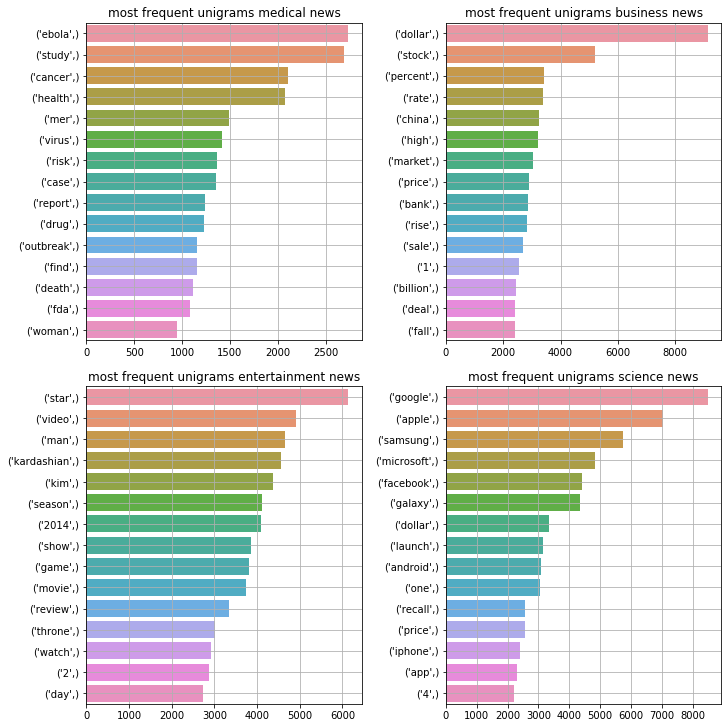

In [111]:
fig,ax=plt.subplots(nrows=2, ncols=2, figsize=(10,10), constrained_layout=True)
sns.barplot(x="count", y="n_gram", data=unigrams_m.head(15), ax=ax[0,0])
ax[0,0].set_title("most frequent unigrams medical news")
ax[0,0].grid(True)
ax[0,0].set_xlabel("")
ax[0,0].set_ylabel("")

sns.barplot(x="count", y="n_gram", data=unigrams_b.head(15), ax=ax[0,1])
ax[0,1].set_title("most frequent unigrams business news")
ax[0,1].grid(True)
ax[0,1].set_xlabel("")
ax[0,1].set_ylabel("")

sns.barplot(x="count", y="n_gram", data=unigrams_e.head(15), ax=ax[1,0])
ax[1,0].set_title("most frequent unigrams entertainment news")
ax[1,0].grid(True)
ax[1,0].set_xlabel("")
ax[1,0].set_ylabel("")

sns.barplot(x="count", y="n_gram", data=unigrams_t.head(15), ax=ax[1,1])
ax[1,1].set_title("most frequent unigrams science news")
ax[1,1].grid(True)
ax[1,1].set_xlabel("")
ax[1,1].set_ylabel("")


plt.show()

potential new features (binary):
 - ebola
 - study
 - cancer
 - health
 - stock
 - video
 - movie
 - review
 - facebook
 - android
 - iphone

In [112]:
# bigrams features train set
train_set["ebola_outbreak"]=train_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "ebola outbreak" in x else 0)
train_set["wall_street"]=train_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "wall street" in x else 0)
train_set["game_throne"]=train_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "game throne" in x else 0)
train_set["star_war"]=train_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "star war" in x else 0)
train_set["box_office"]=train_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "box office" in x else 0)
train_set["samsung_galaxy"]=train_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "samsung galaxy" in x else 0)

# unigrams features train set
train_set["ebola"]=train_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "ebola" in x else 0)
train_set["study"]=train_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "study" in x else 0)
train_set["cancer"]=train_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "cancer" in x else 0)
train_set["health"]=train_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "health" in x else 0)
train_set["stock"]=train_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "stock" in x else 0)
train_set["video"]=train_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "video" in x else 0)
train_set["movie"]=train_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "movie" in x else 0)
train_set["review"]=train_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "review" in x else 0)
train_set["facebook"]=train_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "facebook" in x else 0)
train_set["android"]=train_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "android" in x else 0)
train_set["iphone"]=train_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "iphone" in x else 0)

# bigrams features validation set
val_set["ebola_outbreak"]=val_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "ebola outbreak" in x else 0)
val_set["wall_street"]=val_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "wall street" in x else 0)
val_set["game_throne"]=val_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "game throne" in x else 0)
val_set["star_war"]=val_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "star war" in x else 0)
val_set["box_office"]=val_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "box office" in x else 0)
val_set["samsung_galaxy"]=val_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "samsung galaxy" in x else 0)

# unigrams features validation set
val_set["ebola"]=val_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "ebola" in x else 0)
val_set["study"]=val_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "study" in x else 0)
val_set["cancer"]=val_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "cancer" in x else 0)
val_set["health"]=val_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "health" in x else 0)
val_set["stock"]=val_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "stock" in x else 0)
val_set["video"]=val_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "video" in x else 0)
val_set["movie"]=val_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "movie" in x else 0)
val_set["review"]=val_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "review" in x else 0)
val_set["facebook"]=val_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "facebook" in x else 0)
val_set["android"]=val_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "android" in x else 0)
val_set["iphone"]=val_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "iphone" in x else 0)

# bigrams features test set set
test_set["ebola_outbreak"]=test_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "ebola outbreak" in x else 0)
test_set["wall_street"]=test_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "wall street" in x else 0)
test_set["game_throne"]=test_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "game throne" in x else 0)
test_set["star_war"]=test_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "star war" in x else 0)
test_set["box_office"]=test_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "box office" in x else 0)
test_set["samsung_galaxy"]=test_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "samsung galaxy" in x else 0)

# unigrams features train set
test_set["ebola"]=test_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "ebola" in x else 0)
test_set["study"]=test_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "study" in x else 0)
test_set["cancer"]=test_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "cancer" in x else 0)
test_set["health"]=test_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "health" in x else 0)
test_set["stock"]=test_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "stock" in x else 0)
test_set["video"]=test_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "video" in x else 0)
test_set["movie"]=test_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "movie" in x else 0)
test_set["review"]=test_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "review" in x else 0)
test_set["facebook"]=test_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "facebook" in x else 0)
test_set["android"]=test_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "android" in x else 0)
test_set["iphone"]=test_set.TITLE_cl_nosw_lemma_nosw.apply(lambda x: 1 if "iphone" in x else 0)

In [119]:
# delete old variables
del ner
del vader

##### data sets saving

Here sets after full preprocessing and feature engineering are saved, and here can be loaded.

In [140]:
# # sets saving
# train_set.to_csv(r"data\train_set_full.csv")
# val_set.to_csv(r"data\val_set_full.csv")
# test_set.to_csv(r"data\test_set_full.csv")

In [2]:
# loading sets from csv

# columns with datatype other than str and float, have to be converted
to_convert=["tokens","tokens_no_stopwords", "tokens_cl_nosw_lemma","tokens_cl_nosw_lemma_nosw","tags","tags_count"]

# loading train set csv
train_set=pd.read_csv(r"data\train_set_full.csv",index_col=0)
# convert datatypes to list and dicts (train set)
for column in to_convert:
    train_set[column]=train_set[column].apply(lambda x: ast.literal_eval(x))
    
# loading validation set csv
val_set=pd.read_csv(r"data\val_set_full.csv",index_col=0)
# convert datatypes to list and dicts (validation set)
for column in to_convert:
    val_set[column]=val_set[column].apply(lambda x: ast.literal_eval(x))
    
# loading test set csv
test_set=pd.read_csv(r"data\test_set_full.csv",index_col=0)
# convert datatypes to list and dicts (validation set)
for column in to_convert:
    test_set[column]=test_set[column].apply(lambda x: ast.literal_eval(x))

##### words embeddings
In this section 100-dimensional GloVe vectors are used to convert data for the CNNs

In [3]:
# dictionary inicialization
embeddings_index = {}

# file opening with utf8 encoding (some characters may cause an error)
f = open(r"GloVe\glove.6B.100d.txt", encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found {} word vectors.'.format(len(embeddings_index)))

Found 400000 word vectors.


In [4]:
# look for different-shaped embeddings

# inicialize dict (key: word, value: embedding shape)
words = {}
# position, to check if there is a pattern
iis = []

# loop
for i, word in enumerate(embeddings_index.keys()):
    # current word embedding shape
    shape = embeddings_index[word].shape[0]
    # condtition check (100 because current glove has 100 dimension vectors)
    if shape != 100:
        # saving
        words[word] = shape
        iis.append(i)
        
# check
words

{}

All the embedding has the same dimension, that is good <br>
If the word from dataset can't be found, a special, unknown token OOV has been assigned to it. OOV token is an average of all the other tokens.

In [5]:
# unknown token computation
start = timer()
unknown = sum(embeddings_index.values())/len(embeddings_index)
stop = timer()
print("Execution time: {} seconds".format(round(stop-start, 2)))

Execution time: 0.23 seconds


In [6]:
# saving computed unknown to embedding
embeddings_index["<OOV>"] = unknown

In [7]:
def get_vocabulary(data, return_dataframe = False):
    '''
    function creates vocabulary for given series of sentences
    data - pd.Series with tokens
    return_dataframe - return sorted pandas DataFrame if True 
    
    return vocabulary (dictionary, keys: words, values: counts or dataframe sorted by occurrence)
    '''
    # dictionary inicialization
    vocabulary = {}
        
    # sentence level loop
    for tokens in data:
        #words = sentence.split()
        # word level loop
        for token in tokens:
            if token not in vocabulary.keys():
                vocabulary[token] = 1
            else:
                vocabulary[token] += 1
                
    # sorting
    if return_dataframe:
        vocabulary = pd.DataFrame(vocabulary.items(), columns = ["word", "count"]).sort_values("count", ascending = False)
            
    return vocabulary

In [8]:
def coverage(data, embedding, info = False):
    '''
    function to check coverage with given embedding
    data - pd.Series with text data
    embedding - word embedding dictionary
    info - coverage percentage printed if true - two measures (occurrence weighting and raw)
    
    return covered, non_covered (dicts key: word, value: count) 
    '''
    
    # get vocabulary
    vocabulary = get_vocabulary(data)
    
    # inicialization
    covered = {}
    non_covered = {}
    
    # loop through vocabulary
    for word in vocabulary.keys():
        if word in embedding.keys():
            covered[word] = vocabulary[word]
        else:
            non_covered[word] = vocabulary[word]
    
    # DataFrame conversion
    covered = pd.DataFrame(covered.items(), columns = ["word", "count"]).sort_values("count", ascending = False)
    non_covered = pd.DataFrame(non_covered.items(), columns = ["word", "count"]).sort_values("count", ascending = False)
    
    if info:
        print("Covered words percentage: {}% raw: {}%".format(round(
            100 * covered["count"].sum()/(covered["count"].sum()+non_covered["count"].sum()),
            4), round(100 * covered.shape[0]/(covered.shape[0]+non_covered.shape[0]), 4)))
        print("Non-covered words percentage: {}% raw: {}%".format(round(
            100 * non_covered["count"].sum()/(covered["count"].sum()+non_covered["count"].sum()), 
            4), round(100 * non_covered.shape[0]/(covered.shape[0]+non_covered.shape[0]), 4)))
    
    
    return covered, non_covered

GloVe coverage analysis

In [9]:
# train set
cov, non_cov = coverage(train_set.tokens_cl_nosw_lemma_nosw, embeddings_index, info = True)

Covered words percentage: 98.4027% raw: 81.918%
Non-covered words percentage: 1.5973% raw: 18.082%


In [10]:
# validation set
cov, non_cov = coverage(val_set.tokens_cl_nosw_lemma_nosw, embeddings_index, info = True)

Covered words percentage: 98.4586% raw: 89.7384%
Non-covered words percentage: 1.5414% raw: 10.2616%


pretty high coverage! thats good

In [11]:
# most frequent non covered words 
non_cov.iloc[:30,:]

word  count
19    heartbleed    242
3           andt    233
24         mh370    158
26        selfie    107
77     titanfall     84
58         kimye     70
74        marrie     57
138    sharknado     57
178   smartwatch     51
185      nadella     47
183         tsla     46
45           gox     45
80        abbvie     41
203      mercede     37
160        rowle     37
225       songza     36
66          boee     36
30        measle     34
184    supermoon     33
27        fracke     33
4     chromecast     32
164       iwatch     31
9        diabete     31
137        gosle     31
558      oneplus     30
46        200000     27
79   gigafactory     27
1       fuelband     26
207     degenere     25
210       flappy     24

Sentence max and min lengths are computed below (it is important to know because of padding and filter size in CNN)

In [12]:
maxLen_train=max(train_set.tokens_cl_nosw_lemma_nosw.apply(lambda x: len(x)))
maxLen_valid=max(val_set.tokens_cl_nosw_lemma_nosw.apply(lambda x: len(x)))
maxLen_test=max(test_set.tokens_cl_nosw_lemma_nosw.apply(lambda x: len(x)))
print("the longest title (train set) has {} words".format(maxLen_train))
print("the longest title (validation set) has {} words".format(maxLen_valid))
print("the longest title (test set) has {} words".format(maxLen_test))

minLen_train=min(train_set.tokens_cl_nosw_lemma_nosw.apply(lambda x: len(x)))
minLen_valid=min(val_set.tokens_cl_nosw_lemma_nosw.apply(lambda x: len(x)))
minLen_test=min(test_set.tokens_cl_nosw_lemma_nosw.apply(lambda x: len(x)))
print("\nthe shortest title (train set) has {} words".format(minLen_train))
print("the shortest title (validation set) has {} words".format(minLen_valid))
print("the shortest title (test set) has {} words".format(minLen_test))

the longest title (train set) has 18 words
the longest title (validation set) has 18 words
the longest title (test set) has 16 words

the shortest title (train set) has 1 words
the shortest title (validation set) has 1 words
the shortest title (test set) has 1 words


nice situation, the longest title is in the train set, but there is no big difference between sets, but now I realized that CNN kernel size can not be bigger than min len and filter size=1 has no sense. What is more, variable with lens is normalized, so I have to compute lens again...

In [13]:
# lengths computation (again)
train_set["lens"]=train_set.tokens_cl_nosw_lemma_nosw.apply(lambda sentence: len(sentence))
val_set["lens"]=val_set.tokens_cl_nosw_lemma_nosw.apply(lambda sentence: len(sentence))
test_set["lens"]=test_set.tokens_cl_nosw_lemma_nosw.apply(lambda sentence: len(sentence))

In [14]:
# train legths inspection
train_set.lens.value_counts()

7     60446
6     55032
8     53822
5     39849
9     38778
4     21026
10    20684
11     7952
3      7940
2      2826
12     2562
13      763
1       379
14      222
15       57
16        9
17        5
18        2
Name: lens, dtype: int64

In [15]:
# validation legths inspection
val_set.lens.value_counts()

7     10620
6      9873
8      9500
5      6982
9      6759
4      3750
10     3553
11     1447
3      1418
2       524
12      467
13      130
1        53
14       35
15        7
16        4
18        1
Name: lens, dtype: int64

In [24]:
# test legths inspection
test_set.lens.value_counts()

7     10615
6      9808
8      9344
5      6948
9      6877
10     3657
4      3630
11     1407
3      1405
2       513
12      459
13      132
1        67
14       40
15        7
16        5
Name: lens, dtype: int64

Removing 1- and 2- lens observiations allows to build CNNs with 3 filters, results will be a bit biased but there is no time for preprocessing data again. There are relatively small number of 1- and 2- lens sentences (after preprocessig) 

In [16]:
# indices extraction
train_obs_to_del=train_set.where((train_set.lens==1)|(train_set.lens==2)).dropna().index.tolist()
val_obs_to_del=val_set.where((val_set.lens==1)|(val_set.lens==2)).dropna().index.tolist()
test_obs_to_del=test_set.where((test_set.lens==1)|(test_set.lens==2)).dropna().index.tolist()

# observations removing
train_set.drop(labels=train_obs_to_del, axis=0, inplace=True)
val_set.drop(labels=val_obs_to_del, axis=0, inplace=True)
test_set.drop(labels=test_obs_to_del, axis=0, inplace=True)

In [17]:
# get final training vocabulary
train_vocab = list(get_vocabulary(train_set.tokens_cl_nosw_lemma_nosw).keys())

In [18]:
# build a token dictionary
# inicialization
word_index = {}
# embedding words
words_in_embedding = embeddings_index.keys()
i = 0
# loop through training vocabulary
for word in train_vocab:
    # covered word tokenization
    if word in words_in_embedding:
        word_index[word] = i
        i += 1
    # unknown token
    else:
        if not word_index.get("<OOV>"):
            word_index["<OOV>"] = i
            i += 1

In [19]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Function convert a vector of strings to its token representation with padding (batch training requirement).
    
    X -- sentences vector (strings)
    word_to_index - token dictionary
    max_len - fixed sentence length, shorter sentences are zero-padded 
    
    returns X_indices (padded and tokenized sentences - shape (number of observations, max sentence length))
    """
    
    # number of training examples
    m = X.shape[0]
    
    # inicialization (carry out padding)
    X_indices = np.zeros((m, max_len)) 
    
    # loop through training examples
    for i in range(m):                               
        
        # lowercasting just for safety, splitting sentence into words
        sentence_words = X[i].lower().split()
        
        # column iterator inicialization
        j = 0
        
        # loop through the words in obtained sentence
        for w in sentence_words:
            if w in word_to_index.keys():
                # tokenization saving (covered with embedding)
                X_indices[i, j] = word_to_index[w]
            else:
                # tokenization saving (unknown token)
                X_indices[i, j] = word_to_index["<OOV>"]
                
            # column iterator incrementation
            j = j + 1
            
    return X_indices

In [20]:
# train set data preparation for CNN
X_train_cnn = sentences_to_indices(train_set.TITLE_cl_nosw_lemma_nosw.values, word_index, maxLen_train)

# validation set data preparation for CNN
X_val_cnn = sentences_to_indices(val_set.TITLE_cl_nosw_lemma_nosw.values, word_index, maxLen_train)

In [21]:
# pre-trained embedding matrix preparation

# embedding dimension (GloVe 100 used)   
embedding_dim = 100

# embedding matrix initialization (one zeros row is the Keras requirement)
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

# loop through tokens
for word, i in word_index.items():
    # embedding extraction
    embedding_vector = embeddings_index.get(word)
    # just for safety
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [22]:
# Keras Embedding layer building (not trainable)
embedding_layer = layers.Embedding(len(word_index) + 1,
                                   embedding_dim,
                                   weights=[embedding_matrix],
                                   input_length=maxLen_train,
                                   trainable=False)

#### data preparation for the dense part of the model
Because model has two branches and one of them is the dense one, the features created before have to be extracted (numpy.arrays from pd.DataFrame)

In [23]:
features_for_dense=["org_length", "proc_length", "sentiment", "tag_CARDINAL", "tag_LANGUAGE", "tag_WORK_OF_ART",
                    "tag_ORDINAL", "tag_LOC", "tag_QUANTITY", "tag_DATE", "tag_LAW", "tag_TIME", "tag_TIME", "tag_GPE", 
                    "tag_ORG", "tag_NORP", "tag_PERCENT", "tag_PRODUCT", "tag_MONEY", "tag_EVENT", "tag_FAC", "tag_PERSON",
                    "FDA", "CDC", "Guinea", "China", "Fed", "Ukraine", "GM", "ECB", "Russia", "Amazon", "Kim_Kardashian", 
                    "Justin_Bieber", "Kanye_West", "Selena_Gomez", "Michael_Jackson", "Jay_Z", "HBO", "Lindsay_Lohan", 
                    "Guardians", "Apple", "Microsoft", "Samsung", "Google", "NASA", "Sony", "FCC", "ebola_outbreak", 
                    "wall_street", "game_throne", "star_war", "box_office", "samsung_galaxy", "ebola", "study", "cancer",
                    "health", "stock", "video", "movie", "review", "facebook", "android", "iphone"]

In [24]:
X_train_dense=train_set[features_for_dense].values
X_val_dense=val_set[features_for_dense].values

#### target variable preparation
Because it is a multiclass classification problem, softmax has to be used paired with CategoricalCross entropy loss function. To use mentioned functions target variable has to be converted into the one-hot form.

In [25]:
# labels encoding
le = LabelEncoder()
le.fit(train_set.CATEGORY)
Y_train=np_utils.to_categorical(le.transform(train_set.CATEGORY))
Y_val=np_utils.to_categorical(le.transform(val_set.CATEGORY))

### Modelling

The idea behind the model is as follows:<br>
Word embeddings will be used, so Convolutional branch is needed, and because features were engineered dense branch is needed too.

It is impossible to combine the word embeddings and created features. To solve the problem the two input model is considered. The two branches are: the Convolutional one and dense one. After layers feature extraction (and CNN flattening) the branches are concatenated to feed softmax classifier.

The model is relatively simple and contains one 1D convolition layer with 100 filters of size 3 followed by one 1D MaxPooling layer with window size 2 all followed by Flatten layer. Dense branch is build from one hidden layer with 60 hidden units (65 features was engineered). All activation functions are ReLu except the last one - softmax classifier. The model is optimized with Adam algorithm with standard settings.

No regularization, no dropout, no batch normalization, but very good results :)

Model architecture and summary below.

In [28]:
# Model architecture
def model():
    cnn_input=layers.Input(shape=(maxLen_train,), dtype='int32')
    embeddings=embedding_layer(cnn_input)
    cnn_branch=layers.Conv1D(100, 3, activation='relu', strides=1, padding="valid", use_bias=True)(embeddings)
    cnn_branch=layers.MaxPooling1D(2)(cnn_branch)
    cnn_branch=layers.Flatten()(cnn_branch)

    dense_input=layers.Input(shape=X_train_dense[0].shape)
    dense_branch=layers.Dense(units=60, use_bias=True, activation=activations.relu)(dense_input)

    main_branch=layers.Concatenate()([cnn_branch, dense_branch])
    output=layers.Dense(units=4, activation=activations.softmax)(main_branch)

    model = keras.Model(inputs=[cnn_input,dense_input], outputs=output)
    model.compile(loss=losses.CategoricalCrossentropy(),
                  optimizer=optimizers.Adam())
    return model
model=model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 18)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 18, 100)      3132500     input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 16, 100)      30100       embedding[1][0]                  
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 8, 100)       0           conv1d_1[0][0]                   
______________________________________________________________________________________________

#### Training
The training parameters: 10 epochs and 256 batch size was picked randomly, but it turned out that the results were pretty good. Considering training history, the parameters are good enough.

In [51]:
history = model.fit(x=[X_train_cnn, X_train_dense], y=Y_train, validation_data=([X_val_cnn, X_val_dense], Y_val),
                    epochs=10, batch_size=256)

Train on 309149 samples, validate on 54546 samples
Epoch 1/10
309149/309149 [==============================] - 20s 66us/sample - loss: 0.3852 - val_loss: 0.2997
Epoch 2/10
309149/309149 [==============================] - 20s 63us/sample - loss: 0.2697 - val_loss: 0.2670
Epoch 3/10
309149/309149 [==============================] - 20s 63us/sample - loss: 0.2312 - val_loss: 0.2409
Epoch 4/10
309149/309149 [==============================] - 19s 62us/sample - loss: 0.2096 - val_loss: 0.2306
Epoch 5/10
309149/309149 [==============================] - 19s 63us/sample - loss: 0.1944 - val_loss: 0.2305
Epoch 6/10
309149/309149 [==============================] - 19s 63us/sample - loss: 0.1834 - val_loss: 0.2313
Epoch 7/10
309149/309149 [==============================] - 19s 63us/sample - loss: 0.1748 - val_loss: 0.2235
Epoch 8/10
309149/309149 [==============================] - 19s 63us/sample - loss: 0.1681 - val_loss: 0.2244
Epoch 9/10
309149/309149 [==============================] - 19s 63us/

#### Validation (Validation set predictions)
In this subsection the model is evaluated on the validation set

In [53]:
# predictions
val_preds=model.predict(x=[X_val_cnn, X_val_dense])

In [119]:
# variables conversion to make confusion matrix possible to build
Y_train=le.transform(train_set.CATEGORY)
Y_val=le.transform(val_set.CATEGORY)
Y_val_named=le.inverse_transform(Y_val)
val_preds_named=le.inverse_transform(np.argmax(val_preds,axis=1))

In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    FUNCTION FOUND HERE: https://datascience.stackexchange.com/questions/40067/confusion-matrix-three-classes-python/40068
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix


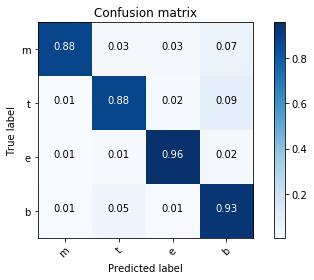

In [128]:
# Confusion matrix for the validation set
cnf_matrix = confusion_matrix(Y_val_named, val_preds_named,labels=train_set.CATEGORY.unique())
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=train_set.CATEGORY.unique(), normalize=True)

#### More epochs - 30
training, validation 

In [29]:
model=model()
history_30 = model.fit(x=[X_train_cnn, X_train_dense], y=Y_train, validation_data=([X_val_cnn, X_val_dense], Y_val),
                       epochs=30, batch_size=256)

Train on 309149 samples, validate on 54546 samples
Epoch 1/30
309149/309149 [==============================] - 20s 64us/sample - loss: 0.3994 - val_loss: 0.3078
Epoch 2/30
309149/309149 [==============================] - 18s 59us/sample - loss: 0.2755 - val_loss: 0.2616
Epoch 3/30
309149/309149 [==============================] - 21s 68us/sample - loss: 0.2353 - val_loss: 0.2500
Epoch 4/30
309149/309149 [==============================] - 27s 87us/sample - loss: 0.2131 - val_loss: 0.2389
Epoch 5/30
309149/309149 [==============================] - 33s 106us/sample - loss: 0.1972 - val_loss: 0.2265
Epoch 6/30
309149/309149 [==============================] - 19s 62us/sample - loss: 0.1854 - val_loss: 0.2312
Epoch 7/30
309149/309149 [==============================] - 19s 60us/sample - loss: 0.1765 - val_loss: 0.2272
Epoch 8/30
309149/309149 [==============================] - 19s 63us/sample - loss: 0.1689 - val_loss: 0.2297
Epoch 9/30
309149/309149 [==============================] - 20s 65us

In [30]:
# predictions
val_preds=model.predict(x=[X_val_cnn, X_val_dense])

In [31]:
# variables conversion to make confusion matrix possible to build
Y_train=le.transform(train_set.CATEGORY)
Y_val=le.transform(val_set.CATEGORY)
Y_val_named=le.inverse_transform(Y_val)
val_preds_named=le.inverse_transform(np.argmax(val_preds,axis=1))

Normalized confusion matrix


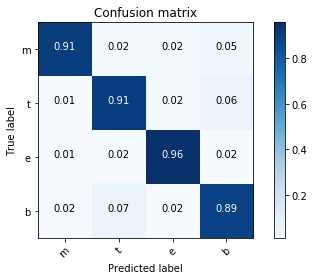

In [34]:
# Confusion matrix for the validation set
cnf_matrix = confusion_matrix(Y_val_named, val_preds_named,labels=train_set.CATEGORY.unique())
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=train_set.CATEGORY.unique(), normalize=True)

after 20 more epochs model learn more about medical and science (technology) classes, but overfitting and confusion with the business occured. It is not surprising especially when looking at "learning curves" which are here simple training report loss, after 10-th epochs increasing overfitting can be observed. Maybe adding one dense layer in main branch will help.

#### Model with additional dense layer in the main branch
Definition, training, validation

In [38]:
def model_deeper_main_branch():
    # Model architecture
    cnn_input=layers.Input(shape=(maxLen_train,), dtype='int32')
    embeddings=embedding_layer(cnn_input)
    cnn_branch=layers.Conv1D(100, 3, activation='relu', strides=1, padding="valid", use_bias=True)(embeddings)
    cnn_branch=layers.MaxPooling1D(2)(cnn_branch)
    cnn_branch=layers.Flatten()(cnn_branch)

    dense_input=layers.Input(shape=X_train_dense[0].shape)
    dense_branch=layers.Dense(units=60, use_bias=True, activation=activations.relu)(dense_input)

    main_branch=layers.Concatenate()([cnn_branch, dense_branch])
    main_branch=layers.Dense(units=430, use_bias=True, activation=activations.relu)(main_branch)
    output=layers.Dense(units=4, activation=activations.softmax)(main_branch)

    model = keras.Model(inputs=[cnn_input,dense_input], outputs=output)
    model.compile(loss=losses.CategoricalCrossentropy(),
                  optimizer=optimizers.Adam())
    
    return model

model_deeper_main_branch=model_deeper_main_branch()
model_deeper_main_branch.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 18)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 18, 100)      3132500     input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 16, 100)      30100       embedding[4][0]                  
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 8, 100)       0           conv1d_4[0][0]                   
____________________________________________________________________________________________

In [40]:
Y_train=np_utils.to_categorical(le.transform(train_set.CATEGORY))
Y_val=np_utils.to_categorical(le.transform(val_set.CATEGORY))

In [41]:
history_mdmb = model_deeper_main_branch.fit(
    x=[X_train_cnn, X_train_dense], y=Y_train, validation_data=([X_val_cnn, X_val_dense], Y_val),
    epochs=15, batch_size=256)

Train on 309149 samples, validate on 54546 samples
Epoch 1/15
309149/309149 [==============================] - 27s 89us/sample - loss: 0.3443 - val_loss: 0.2671
Epoch 2/15
309149/309149 [==============================] - 28s 91us/sample - loss: 0.2318 - val_loss: 0.2285
Epoch 3/15
309149/309149 [==============================] - 27s 87us/sample - loss: 0.1925 - val_loss: 0.2179
Epoch 4/15
309149/309149 [==============================] - 27s 87us/sample - loss: 0.1659 - val_loss: 0.2163
Epoch 5/15
309149/309149 [==============================] - 27s 88us/sample - loss: 0.1426 - val_loss: 0.2220
Epoch 6/15
309149/309149 [==============================] - 28s 91us/sample - loss: 0.1223 - val_loss: 0.2260
Epoch 7/15
309149/309149 [==============================] - 27s 88us/sample - loss: 0.1045 - val_loss: 0.2415
Epoch 8/15
309149/309149 [==============================] - 26s 85us/sample - loss: 0.0894 - val_loss: 0.2496
Epoch 9/15
309149/309149 [==============================] - 27s 86us/

In [42]:
# predictions
train_preds=model_deeper_main_branch.predict(x=[X_train_cnn, X_train_dense])
val_preds=model_deeper_main_branch.predict(x=[X_val_cnn, X_val_dense])

In [45]:
# variables conversion to make confusion matrix possible to build
Y_train=train_set.CATEGORY
train_preds_named=le.inverse_transform(np.argmax(train_preds,axis=1))
Y_val=le.transform(val_set.CATEGORY)
Y_val_named=le.inverse_transform(Y_val)
val_preds_named=le.inverse_transform(np.argmax(val_preds,axis=1))

--- train set ---
Normalized confusion matrix


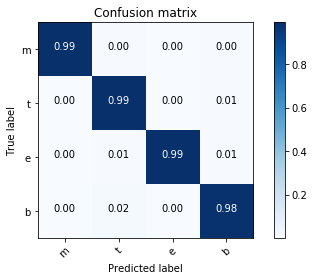

In [47]:
# Confusion matrices
print("--- train set ---")
cnf_matrix = confusion_matrix(Y_train, train_preds_named,labels=train_set.CATEGORY.unique())
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=train_set.CATEGORY.unique(), normalize=True)

--- validation set ---
Normalized confusion matrix


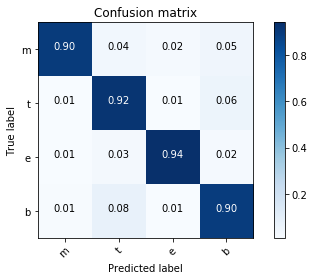

In [48]:
print("--- validation set ---")
cnf_matrix = confusion_matrix(Y_val_named, val_preds_named,labels=train_set.CATEGORY.unique())
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=train_set.CATEGORY.unique(), normalize=True)

accuracy has lower variance for classes.
#### Model with additional dense layer in the main branch + dropout
Definition, training, validation

In [49]:
def model_deeper_main_branch_dropout_04():
    # Model architecture
    cnn_input=layers.Input(shape=(maxLen_train,), dtype='int32')
    embeddings=embedding_layer(cnn_input)
    cnn_branch=layers.Conv1D(100, 3, activation='relu', strides=1, padding="valid", use_bias=True)(embeddings)
    cnn_branch=layers.MaxPooling1D(2)(cnn_branch)
    cnn_branch=layers.Flatten()(cnn_branch)

    dense_input=layers.Input(shape=X_train_dense[0].shape)
    dense_branch=layers.Dense(units=60, use_bias=True, activation=activations.relu)(dense_input)

    main_branch=layers.Concatenate()([cnn_branch, dense_branch])
    main_branch=layers.Dense(units=430, use_bias=True, activation=activations.relu)(main_branch)
    main_branch=layers.Dropout(rate=0.4)(main_branch)
    
    output=layers.Dense(units=4, activation=activations.softmax)(main_branch)

    model = keras.Model(inputs=[cnn_input,dense_input], outputs=output)
    model.compile(loss=losses.CategoricalCrossentropy(),
                  optimizer=optimizers.Adam())
    
    return model

model_deeper_main_branch_dropout_04=model_deeper_main_branch_dropout_04()
model_deeper_main_branch_dropout_04.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 18)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 18, 100)      3132500     input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 16, 100)      30100       embedding[5][0]                  
__________________________________________________________________________________________________
max_pooling1d_5 (MaxPooling1D)  (None, 8, 100)       0           conv1d_5[0][0]                   
____________________________________________________________________________________________

In [50]:
Y_train=np_utils.to_categorical(le.transform(train_set.CATEGORY))
Y_val=np_utils.to_categorical(le.transform(val_set.CATEGORY))

history_mdmbd04 = model_deeper_main_branch_dropout_04.fit(
    x=[X_train_cnn, X_train_dense], y=Y_train, validation_data=([X_val_cnn, X_val_dense], Y_val),
    epochs=15, batch_size=256)

Train on 309149 samples, validate on 54546 samples
Epoch 1/15
309149/309149 [==============================] - 28s 89us/sample - loss: 0.3570 - val_loss: 0.2666
Epoch 2/15
309149/309149 [==============================] - 28s 90us/sample - loss: 0.2413 - val_loss: 0.2315
Epoch 3/15
309149/309149 [==============================] - 28s 90us/sample - loss: 0.2061 - val_loss: 0.2205
Epoch 4/15
309149/309149 [==============================] - 27s 86us/sample - loss: 0.1836 - val_loss: 0.2125
Epoch 5/15
309149/309149 [==============================] - 28s 90us/sample - loss: 0.1672 - val_loss: 0.2165
Epoch 6/15
309149/309149 [==============================] - 26s 84us/sample - loss: 0.1539 - val_loss: 0.2099
Epoch 7/15
309149/309149 [==============================] - 26s 85us/sample - loss: 0.1422 - val_loss: 0.2155
Epoch 8/15
309149/309149 [==============================] - 29s 95us/sample - loss: 0.1325 - val_loss: 0.2226
Epoch 9/15
309149/309149 [==============================] - 27s 88us/

It looks like overfitting is reduced, but it is important to see the results

In [52]:
# predictions
train_preds=model_deeper_main_branch_dropout_04.predict(x=[X_train_cnn, X_train_dense])
val_preds=model_deeper_main_branch_dropout_04.predict(x=[X_val_cnn, X_val_dense])

In [53]:
# variables conversion to make confusion matrix possible to build
Y_train=train_set.CATEGORY
train_preds_named=le.inverse_transform(np.argmax(train_preds,axis=1))
Y_val=val_set.CATEGORY
val_preds_named=le.inverse_transform(np.argmax(val_preds,axis=1))

--- train set ---
Normalized confusion matrix


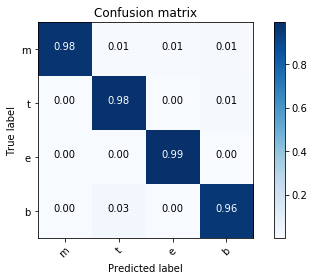

In [54]:
# Confusion matrices
print("--- train set ---")
cnf_matrix = confusion_matrix(Y_train, train_preds_named,labels=train_set.CATEGORY.unique())
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=train_set.CATEGORY.unique(), normalize=True)

--- validation set ---
Normalized confusion matrix


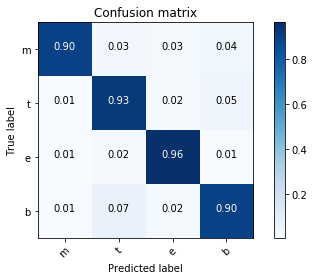

In [55]:
print("--- validation set ---")
cnf_matrix = confusion_matrix(Y_val_named, val_preds_named,labels=train_set.CATEGORY.unique())
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=train_set.CATEGORY.unique(), normalize=True)

The best model so far, maybe a bit of regularization and more epochs would help achive even better results
#### Model with additional dense layer in the main branch + dropout + L2 regularization, 30 epochs
Definition, training, validation

In [56]:
def model_deeper_main_branch_dropout_04_L200005():
    # Model architecture
    cnn_input=layers.Input(shape=(maxLen_train,), dtype='int32')
    embeddings=embedding_layer(cnn_input)
    cnn_branch=layers.Conv1D(100, 3, activation='relu', strides=1, padding="valid", use_bias=True)(embeddings)
    cnn_branch=layers.MaxPooling1D(2)(cnn_branch)
    cnn_branch=layers.Flatten()(cnn_branch)

    dense_input=layers.Input(shape=X_train_dense[0].shape)
    dense_branch=layers.Dense(units=60, use_bias=True, activation=activations.relu)(dense_input)

    main_branch=layers.Concatenate()([cnn_branch, dense_branch])
    main_branch=layers.Dense(units=430, use_bias=True, activation=activations.relu, 
                             kernel_regularizer=regularizers.l2(l=0.00005))(main_branch)
    main_branch=layers.Dropout(rate=0.4)(main_branch)
    
    output=layers.Dense(units=4, activation=activations.softmax)(main_branch)

    model = keras.Model(inputs=[cnn_input,dense_input], outputs=output)
    model.compile(loss=losses.CategoricalCrossentropy(),
                  optimizer=optimizers.Adam())
    
    return model

model_deeper_main_branch_dropout_04_L200005=model_deeper_main_branch_dropout_04_L200005()
model_deeper_main_branch_dropout_04_L200005.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 18)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 18, 100)      3132500     input_13[0][0]                   
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 16, 100)      30100       embedding[6][0]                  
__________________________________________________________________________________________________
max_pooling1d_6 (MaxPooling1D)  (None, 8, 100)       0           conv1d_6[0][0]                   
____________________________________________________________________________________________

In [57]:
Y_train=np_utils.to_categorical(le.transform(train_set.CATEGORY))
Y_val=np_utils.to_categorical(le.transform(val_set.CATEGORY))

history_mdmbd04L20005_30 = model_deeper_main_branch_dropout_04_L200005.fit(
    x=[X_train_cnn, X_train_dense], y=Y_train, validation_data=([X_val_cnn, X_val_dense], Y_val),
    epochs=30, batch_size=256)

Train on 309149 samples, validate on 54546 samples
Epoch 1/30
309149/309149 [==============================] - 30s 97us/sample - loss: 0.3692 - val_loss: 0.2901
Epoch 2/30
309149/309149 [==============================] - 29s 94us/sample - loss: 0.2595 - val_loss: 0.2545
Epoch 3/30
309149/309149 [==============================] - 29s 93us/sample - loss: 0.2277 - val_loss: 0.2409
Epoch 4/30
309149/309149 [==============================] - 27s 87us/sample - loss: 0.2094 - val_loss: 0.2372
Epoch 5/30
309149/309149 [==============================] - 28s 91us/sample - loss: 0.1978 - val_loss: 0.2422
Epoch 6/30
309149/309149 [==============================] - 27s 88us/sample - loss: 0.1883 - val_loss: 0.2400
Epoch 7/30
309149/309149 [==============================] - 28s 91us/sample - loss: 0.1810 - val_loss: 0.2498
Epoch 8/30
309149/309149 [==============================] - 27s 89us/sample - loss: 0.1757 - val_loss: 0.2373
Epoch 9/30
309149/309149 [==============================] - 27s 88us/

In [58]:
# predictions
train_preds=model_deeper_main_branch_dropout_04_L200005.predict(x=[X_train_cnn, X_train_dense])
val_preds=model_deeper_main_branch_dropout_04_L200005.predict(x=[X_val_cnn, X_val_dense])

In [59]:
# variables conversion to make confusion matrix possible to build
Y_train=train_set.CATEGORY
train_preds_named=le.inverse_transform(np.argmax(train_preds,axis=1))
Y_val=val_set.CATEGORY
val_preds_named=le.inverse_transform(np.argmax(val_preds,axis=1))

--- train set ---
Normalized confusion matrix


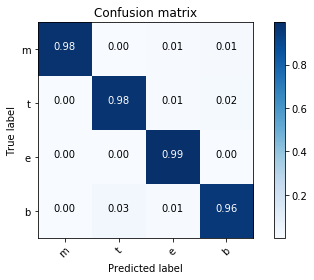

In [60]:
# Confusion matrices
print("--- train set ---")
cnf_matrix = confusion_matrix(Y_train, train_preds_named,labels=train_set.CATEGORY.unique())
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=train_set.CATEGORY.unique(), normalize=True)

--- validation set ---
Normalized confusion matrix


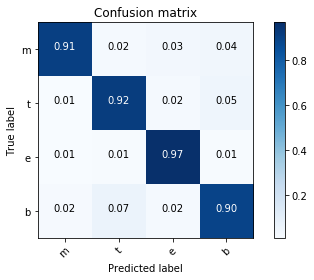

In [61]:
print("--- validation set ---")
cnf_matrix = confusion_matrix(Y_val_named, val_preds_named,labels=train_set.CATEGORY.unique())
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=train_set.CATEGORY.unique(), normalize=True)

a bit better results, but not so much, maybe regularization should be bigger
#### Model with additional dense layer in the main branch + dropout + L2 regularization (ten times bigger), 30 epochs
Definition, training, validation

In [62]:
def model_deeper_main_branch_dropout_04_L20005():
    # Model architecture
    cnn_input=layers.Input(shape=(maxLen_train,), dtype='int32')
    embeddings=embedding_layer(cnn_input)
    cnn_branch=layers.Conv1D(100, 3, activation='relu', strides=1, padding="valid", use_bias=True)(embeddings)
    cnn_branch=layers.MaxPooling1D(2)(cnn_branch)
    cnn_branch=layers.Flatten()(cnn_branch)

    dense_input=layers.Input(shape=X_train_dense[0].shape)
    dense_branch=layers.Dense(units=60, use_bias=True, activation=activations.relu)(dense_input)

    main_branch=layers.Concatenate()([cnn_branch, dense_branch])
    main_branch=layers.Dense(units=430, use_bias=True, activation=activations.relu, 
                             kernel_regularizer=regularizers.l2(l=0.0005))(main_branch)
    main_branch=layers.Dropout(rate=0.4)(main_branch)
    
    output=layers.Dense(units=4, activation=activations.softmax)(main_branch)

    model = keras.Model(inputs=[cnn_input,dense_input], outputs=output)
    model.compile(loss=losses.CategoricalCrossentropy(),
                  optimizer=optimizers.Adam())
    
    return model

model_deeper_main_branch_dropout_04_L20005=model_deeper_main_branch_dropout_04_L20005()
model_deeper_main_branch_dropout_04_L20005.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 18)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 18, 100)      3132500     input_15[0][0]                   
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16, 100)      30100       embedding[7][0]                  
__________________________________________________________________________________________________
max_pooling1d_7 (MaxPooling1D)  (None, 8, 100)       0           conv1d_7[0][0]                   
____________________________________________________________________________________________

In [63]:
Y_train=np_utils.to_categorical(le.transform(train_set.CATEGORY))
Y_val=np_utils.to_categorical(le.transform(val_set.CATEGORY))

history_mdmbd04L2005_30 = model_deeper_main_branch_dropout_04_L20005.fit(
    x=[X_train_cnn, X_train_dense], y=Y_train, validation_data=([X_val_cnn, X_val_dense], Y_val),
    epochs=30, batch_size=256)

Train on 309149 samples, validate on 54546 samples
Epoch 1/30
309149/309149 [==============================] - 39s 126us/sample - loss: 0.4311 - val_loss: 0.3017
Epoch 2/30
309149/309149 [==============================] - 30s 96us/sample - loss: 0.2817 - val_loss: 0.2673
Epoch 3/30
309149/309149 [==============================] - 30s 96us/sample - loss: 0.2529 - val_loss: 0.2588
Epoch 4/30
309149/309149 [==============================] - 30s 97us/sample - loss: 0.2370 - val_loss: 0.2567
Epoch 5/30
309149/309149 [==============================] - 30s 96us/sample - loss: 0.2267 - val_loss: 0.2498
Epoch 6/30
309149/309149 [==============================] - 30s 96us/sample - loss: 0.2183 - val_loss: 0.2492
Epoch 7/30
309149/309149 [==============================] - 30s 96us/sample - loss: 0.2116 - val_loss: 0.2556
Epoch 8/30
309149/309149 [==============================] - 30s 96us/sample - loss: 0.2061 - val_loss: 0.2464
Epoch 9/30
309149/309149 [==============================] - 30s 96us

In [64]:
# predictions
train_preds=model_deeper_main_branch_dropout_04_L20005.predict(x=[X_train_cnn, X_train_dense])
val_preds=model_deeper_main_branch_dropout_04_L20005.predict(x=[X_val_cnn, X_val_dense])

In [65]:
# variables conversion to make confusion matrix possible to build
Y_train=train_set.CATEGORY
train_preds_named=le.inverse_transform(np.argmax(train_preds,axis=1))
Y_val=val_set.CATEGORY
val_preds_named=le.inverse_transform(np.argmax(val_preds,axis=1))

In [66]:
# variables conversion to make confusion matrix possible to build
Y_train=train_set.CATEGORY
train_preds_named=le.inverse_transform(np.argmax(train_preds,axis=1))
Y_val=val_set.CATEGORY
val_preds_named=le.inverse_transform(np.argmax(val_preds,axis=1))

--- train set ---
Normalized confusion matrix


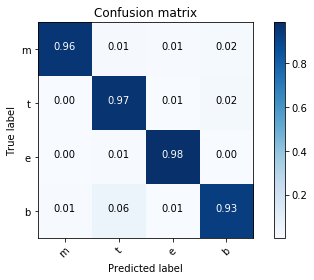

In [67]:
# Confusion matrices
print("--- train set ---")
cnf_matrix = confusion_matrix(Y_train, train_preds_named,labels=train_set.CATEGORY.unique())
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=train_set.CATEGORY.unique(), normalize=True)

--- validation set ---
Normalized confusion matrix


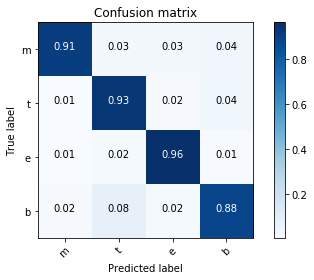

In [68]:
print("--- validation set ---")
cnf_matrix = confusion_matrix(Y_val_named, val_preds_named,labels=train_set.CATEGORY.unique())
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=train_set.CATEGORY.unique(), normalize=True)

Worse results, model with one more dense layer in main branch below
#### Model with additional dense layer in the main branch + dropout + L2 regularization (ten times bigger), and one more dense layer,  15 epochs
Definition, training, validation

In [70]:
def model_deeper_main_branch_dropout_04_L20005_dense():
    # Model architecture
    cnn_input=layers.Input(shape=(maxLen_train,), dtype='int32')
    embeddings=embedding_layer(cnn_input)
    cnn_branch=layers.Conv1D(100, 3, activation='relu', strides=1, padding="valid", use_bias=True)(embeddings)
    cnn_branch=layers.MaxPooling1D(2)(cnn_branch)
    cnn_branch=layers.Flatten()(cnn_branch)

    dense_input=layers.Input(shape=X_train_dense[0].shape)
    dense_branch=layers.Dense(units=60, use_bias=True, activation=activations.relu)(dense_input)

    main_branch=layers.Concatenate()([cnn_branch, dense_branch])
    main_branch=layers.Dense(units=430, use_bias=True, activation=activations.relu, 
                             kernel_regularizer=regularizers.l2(l=0.0005))(main_branch)
    main_branch=layers.Dropout(rate=0.4)(main_branch)
    main_branch=layers.Dense(units=215, use_bias=True, activation=activations.relu)(main_branch)
    
    output=layers.Dense(units=4, activation=activations.softmax)(main_branch)

    model = keras.Model(inputs=[cnn_input,dense_input], outputs=output)
    model.compile(loss=losses.CategoricalCrossentropy(),
                  optimizer=optimizers.Adam())
    
    return model

model_deeper_main_branch_dropout_04_L20005_dense=model_deeper_main_branch_dropout_04_L20005_dense()
model_deeper_main_branch_dropout_04_L20005_dense.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 18)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 18, 100)      3132500     input_19[0][0]                   
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 16, 100)      30100       embedding[9][0]                  
__________________________________________________________________________________________________
max_pooling1d_9 (MaxPooling1D)  (None, 8, 100)       0           conv1d_9[0][0]                   
____________________________________________________________________________________________

In [71]:
Y_train=np_utils.to_categorical(le.transform(train_set.CATEGORY))
Y_val=np_utils.to_categorical(le.transform(val_set.CATEGORY))

history_mdmbd04L2005_dense_15 = model_deeper_main_branch_dropout_04_L20005_dense.fit(
    x=[X_train_cnn, X_train_dense], y=Y_train, validation_data=([X_val_cnn, X_val_dense], Y_val),
    epochs=15, batch_size=256)

Train on 309149 samples, validate on 54546 samples
Epoch 1/15
309149/309149 [==============================] - 32s 103us/sample - loss: 0.4311 - val_loss: 0.3042
Epoch 2/15
309149/309149 [==============================] - 31s 100us/sample - loss: 0.2834 - val_loss: 0.2692
Epoch 3/15
309149/309149 [==============================] - 30s 97us/sample - loss: 0.2551 - val_loss: 0.2594
Epoch 4/15
309149/309149 [==============================] - 30s 97us/sample - loss: 0.2381 - val_loss: 0.2544
Epoch 5/15
309149/309149 [==============================] - 30s 96us/sample - loss: 0.2272 - val_loss: 0.2555
Epoch 6/15
309149/309149 [==============================] - 30s 98us/sample - loss: 0.2188 - val_loss: 0.2499
Epoch 7/15
309149/309149 [==============================] - 30s 98us/sample - loss: 0.2113 - val_loss: 0.2472
Epoch 8/15
309149/309149 [==============================] - 30s 96us/sample - loss: 0.2064 - val_loss: 0.2476
Epoch 9/15
309149/309149 [==============================] - 30s 97u

In [72]:
# predictions
train_preds=model_deeper_main_branch_dropout_04_L20005_dense.predict(x=[X_train_cnn, X_train_dense])
val_preds=model_deeper_main_branch_dropout_04_L20005_dense.predict(x=[X_val_cnn, X_val_dense])

In [73]:
# variables conversion to make confusion matrix possible to build
Y_train=train_set.CATEGORY
train_preds_named=le.inverse_transform(np.argmax(train_preds,axis=1))
Y_val=val_set.CATEGORY
val_preds_named=le.inverse_transform(np.argmax(val_preds,axis=1))

In [74]:
# variables conversion to make confusion matrix possible to build
Y_train=train_set.CATEGORY
train_preds_named=le.inverse_transform(np.argmax(train_preds,axis=1))
Y_val=val_set.CATEGORY
val_preds_named=le.inverse_transform(np.argmax(val_preds,axis=1))

--- train set ---
Normalized confusion matrix


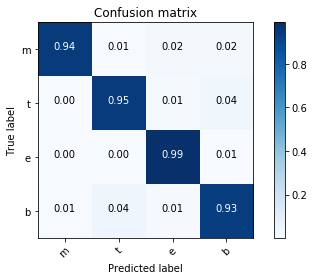

In [75]:
# Confusion matrices
print("--- train set ---")
cnf_matrix = confusion_matrix(Y_train, train_preds_named,labels=train_set.CATEGORY.unique())
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=train_set.CATEGORY.unique(), normalize=True)

--- validation set ---
Normalized confusion matrix


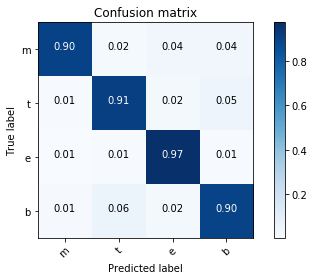

In [76]:
print("--- validation set ---")
cnf_matrix = confusion_matrix(Y_val_named, val_preds_named,labels=train_set.CATEGORY.unique())
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=train_set.CATEGORY.unique(), normalize=True)

The results are a bit worse, but overfitting is much lower, maybe longer training can help, but to prevent overfitting dropout 0.3 is added on the next layer and 0.4 dropout is reduced to 0.3.
#### Model with additional dense layer in the main branch + dropout + L2 regularization (ten times bigger), and one more dense layer,  20 epochs
Definition, training, validation

In [83]:
def model_deeper_main_branch_dropout_03_L20005_dense_drop_03():
    # Model architecture
    cnn_input=layers.Input(shape=(maxLen_train,), dtype='int32')
    embeddings=embedding_layer(cnn_input)
    cnn_branch=layers.Conv1D(100, 3, activation='relu', strides=1, padding="valid", use_bias=True)(embeddings)
    cnn_branch=layers.MaxPooling1D(2)(cnn_branch)
    cnn_branch=layers.Flatten()(cnn_branch)

    dense_input=layers.Input(shape=X_train_dense[0].shape)
    dense_branch=layers.Dense(units=60, use_bias=True, activation=activations.relu)(dense_input)

    main_branch=layers.Concatenate()([cnn_branch, dense_branch])
    main_branch=layers.Dense(units=430, use_bias=True, activation=activations.relu, 
                             kernel_regularizer=regularizers.l2(l=0.0005))(main_branch)
    main_branch=layers.Dropout(rate=0.3)(main_branch)
    main_branch=layers.Dense(units=215, use_bias=True, activation=activations.relu)(main_branch)
    main_branch=layers.Dropout(rate=0.3)(main_branch)
    
    output=layers.Dense(units=4, activation=activations.softmax)(main_branch)

    model = keras.Model(inputs=[cnn_input,dense_input], outputs=output)
    model.compile(loss=losses.CategoricalCrossentropy(),
                  optimizer=optimizers.Adam())
    
    return model

model_deeper_main_branch_dropout_03_L20005_dense_drop_03=model_deeper_main_branch_dropout_03_L20005_dense_drop_03()
model_deeper_main_branch_dropout_03_L20005_dense_drop_03.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 18)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 18, 100)      3132500     input_23[0][0]                   
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 16, 100)      30100       embedding[11][0]                 
__________________________________________________________________________________________________
max_pooling1d_11 (MaxPooling1D) (None, 8, 100)       0           conv1d_11[0][0]                  
____________________________________________________________________________________________

In [84]:
Y_train=np_utils.to_categorical(le.transform(train_set.CATEGORY))
Y_val=np_utils.to_categorical(le.transform(val_set.CATEGORY))

history_mdmbd03L2005_dense_drop03_20 = model_deeper_main_branch_dropout_03_L20005_dense_drop_03.fit(
    x=[X_train_cnn, X_train_dense], y=Y_train, validation_data=([X_val_cnn, X_val_dense], Y_val),
    epochs=20, batch_size=256)

Train on 309149 samples, validate on 54546 samples
Epoch 1/20
309149/309149 [==============================] - 32s 105us/sample - loss: 0.4243 - val_loss: 0.3016
Epoch 2/20
309149/309149 [==============================] - 31s 102us/sample - loss: 0.2810 - val_loss: 0.2705
Epoch 3/20
309149/309149 [==============================] - 31s 100us/sample - loss: 0.2513 - val_loss: 0.2633
Epoch 4/20
309149/309149 [==============================] - 31s 99us/sample - loss: 0.2347 - val_loss: 0.2523
Epoch 5/20
309149/309149 [==============================] - 31s 100us/sample - loss: 0.2243 - val_loss: 0.2610
Epoch 6/20
309149/309149 [==============================] - 31s 99us/sample - loss: 0.2155 - val_loss: 0.2471
Epoch 7/20
309149/309149 [==============================] - 31s 100us/sample - loss: 0.2082 - val_loss: 0.2464
Epoch 8/20
309149/309149 [==============================] - 31s 100us/sample - loss: 0.2018 - val_loss: 0.2466
Epoch 9/20
309149/309149 [==============================] - 31s

In [85]:
# predictions
train_preds=model_deeper_main_branch_dropout_03_L20005_dense_drop_03.predict(x=[X_train_cnn, X_train_dense])
val_preds=model_deeper_main_branch_dropout_03_L20005_dense_drop_03.predict(x=[X_val_cnn, X_val_dense])

In [86]:
# variables conversion to make confusion matrix possible to build
Y_train=train_set.CATEGORY
train_preds_named=le.inverse_transform(np.argmax(train_preds,axis=1))
Y_val=val_set.CATEGORY
val_preds_named=le.inverse_transform(np.argmax(val_preds,axis=1))

--- train set ---
Normalized confusion matrix


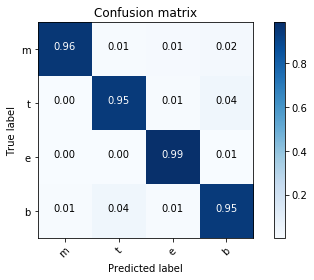

In [87]:
# Confusion matrices
print("--- train set ---")
cnf_matrix = confusion_matrix(Y_train, train_preds_named,labels=train_set.CATEGORY.unique())
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=train_set.CATEGORY.unique(), normalize=True)

--- validation set ---
Normalized confusion matrix


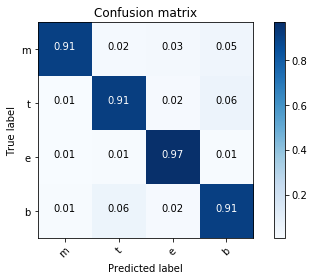

In [88]:
print("--- validation set ---")
cnf_matrix = confusion_matrix(Y_val_named, val_preds_named,labels=train_set.CATEGORY.unique())
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=train_set.CATEGORY.unique(), normalize=True)

This model is considered as the best one, the highest and equal accuracy on each category except the entertainment one which is near perfect. What is important overfitting is one of the lowest.
#### The best model evaluation (test set)

In [89]:
# test set data preparation
X_test_cnn = sentences_to_indices(test_set.TITLE_cl_nosw_lemma_nosw.values, word_index, maxLen_train)
X_test_dense=test_set[features_for_dense].values
Y_test=np_utils.to_categorical(le.transform(test_set.CATEGORY))

In [90]:
# predictions
test_preds=model_deeper_main_branch_dropout_03_L20005_dense_drop_03.predict(x=[X_test_cnn, X_test_dense])

In [95]:
# variables conversion to make confusion matrix possible to build
Y_test=test_set.CATEGORY
test_preds_named=le.inverse_transform(np.argmax(test_preds,axis=1))

--- test set ---
Normalized confusion matrix


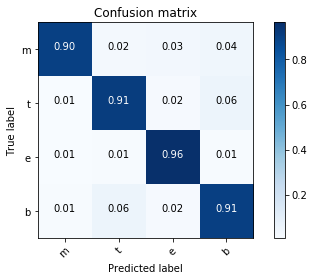

In [97]:
# Confusion matrix
print("--- test set ---")
cnf_matrix = confusion_matrix(Y_test_named, test_preds_named,labels=train_set.CATEGORY.unique())
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=train_set.CATEGORY.unique(), normalize=True)

### Summary
The model is pretty simple itself, but the results are pretty good, at least 0.9 percent of good predictions for each class and 0.96 for the easiest one (entertainment). By looking at the confusion matrix it can be concluded that business category is the most confusing what is not surprising because science and health are categories closely related to business. Thanks to detailed feature engineering and usage GloVe words embeddings also, the results are very good. Dense branch worked well even with sparse features. Detailed cleaning and stopwords removing helped too, thanks to that GloVe coverage was very high and there were no big information losses. Dense branch extract informations from words deleted from Embeddings and not covered by them. Dropout and regularization added to the model helped too and whats very important - reduced overfitting even when more layers were added.